# Translation Invariance of a Simple CNN

We aim to prove that a simple convolutional neural network (CNN) is invariant under small image translations. Intuitively, we hope that any translation that doesn't lose information will correspond to the same label. 

It might be somewhat unrealistic to expect to get full translational invariance, for several reasons. First, we can likely only hope to have this invariance certified for all images in the training/testing set. Providing a general proof may be infeasible. Further, the following papers highlight issues with getting invariance in CNNs for serveral reasons such as issues with striding/subsampling

- [Why do deep convolutional networks generalize so poorly to
small image transformations?](https://jmlr.org/papers/volume20/19-519/19-519.pdf)
- [Tracking translation invariance in CNNs](https://arxiv.org/abs/2104.05997)
- [Stride and translation invariancs in CNNs](https://arxiv.org/pdf/2103.10097.pdf)

In this notebook, we are working with the hypothesis that translational invariance is achievable. From there we hope to certify the invariance of any fixed image by passing it through the network.

For a fixed image $A$ we can translate $A$ (down, left) and (up, right) via (left, right) action by $S$ and $S' = S^T$, respectively. Where $S$ is a matrix with 1s along the subdiagonal and zeros everywhere else.

## A Naive Verification Condition 

We could simply enumerate all translates of $A$; however, this is expensive. Given an $n \times m$ image, there are $nm$ translates of $A$. So we propose a methodolgy of providing a continous artefact that encapsulates the data of all of these translates concisely. 

For a moment, let us aim to only certify invariance under downward translation. We then hope to show that for all $t \in (0, a)$, $S^t A$ is classified the same as $A$. This raises a few important questions, like what is $S^t$ for real-valued $t$? What does "the same" mean here?

We define $S^t$ as $e^{t \log S}$. However, we can only define $\log S$ whenever $S$ is invertible, and notably our shift matrix $S$ is not! We can try to skirt around this by adding $\epsilon I$ and then taking the logarithm of the resulting matrix $\epsilon I + S$. This is unfortunately numerically stable for small $\epsilon$, but seems to stabilize around $\epsilon = 0.8$ or so. It is unclear if this is prohibitively large or not. Initial sketches/experiments suggest not.

"The same" here could mean outputting the same output class, or perhaps more strongly that the outputs are close together in output space (say in some norm ball). The choice of equivalence right now doesn't seem to matter too much. For ease we can assume we just want the weaker notion of the same output class --- which means that the `argmax` of the output is the same across all translates of $A$.

Our proof goals now shift from brute forcing all of the translates of $A$ to instead showing that the interval $(0 ,a)$ gets mapped to the same output class under $t \mapsto N (e^{t \log S} A)$. In conjunction with this, we hope to show that our error is sufficiently bounded so that when $t \in \mathbb{N}$, the classification of $e^{t \log S} A$ meaningfully reflects the classifcation of $S^t A$ (here the exponent is just repeated application of $S$).

After achieving this verification of translation in only one direction we would want to show that we have multivariate invariance under the following map,

$$ (q, r, s, t) \mapsto N(e^{q \log S} e^{r \log S^T} A e^{s \log S} e^{t \log S^T}) $$
Intuitively, this would show that we have full translation invariance in any direction. Again, we would put appropriate ranges on these variables so that we don't have to worry about losing data through truncation of the image. Moreover, we could put further inequalities on these variables as to represent each translate only once.

To see this last point more, note that something like "translate first left 5 and then right 4" could instead be captured by just translating left 1 and not at all rightward. We may wish to handle these sorts of ambiguities for convenience to give a nicer proof goal; however, they likely wouldn't cause any semantic issues.

## Side Notes

There may be some further simplification to be had that utilizes the fact that $e^{S^T} = (e^S)^T$

TODO: JB idea, switch to a permutation matix with a 1 at top right

In [1]:
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import scipy
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
import random

In [3]:
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX.reshape(-1,28,28,1)
testX = testX.reshape(-1,28,28,1) 
trainX = trainX / 255.0
testX = testX / 255.0

In [4]:
S_orig = np.array([[(1 if i - 1 == j else 0) for j in range(28)]for i in range(28)])
Sprime_orig = np.array([[(1 if i + 1 == j else 0) for j in range(28)]for i in range(28)])

def shift_image(image, dx, dy):
    image = np.reshape(image, (28, 28,))
    while dx != 0 and dy != 0:
        # left
        if dx < 0:
            image = np.dot(image, S_orig)
            dx += 1
        # right
        if dx > 0:
            image = np.dot(image, Sprime_orig)
            dx -= 1
        # down
        if dy > 0:
            image = np.dot(S_orig, image)
            dy -= 1
        # up
        if dy < 0:
            image = np.dot(Sprime_orig, image)
            dy += 1
    return image

People just toss data augmentation at the problem and cross their fingers

In [5]:
trainX_aug = []
trainY_aug = []
for image, label in zip(trainX, trainY):
    trainX_aug.append(np.reshape(image, (28, 28,)))
    trainY_aug.append(label)
    for i in range(1, 6):
        for j in range(1, 6):
            if random.random() < 0.15:
                trainX_aug.append(np.reshape(shift_image(image, i, j), (28, 28,)))
                trainY_aug.append(label)
# shuffle_idxs = np.random.permutation(len(trainX_aug))
trainX = np.array(trainX_aug).reshape(-1, 28, 28, 1)
trainY = np.array(trainY_aug)

1


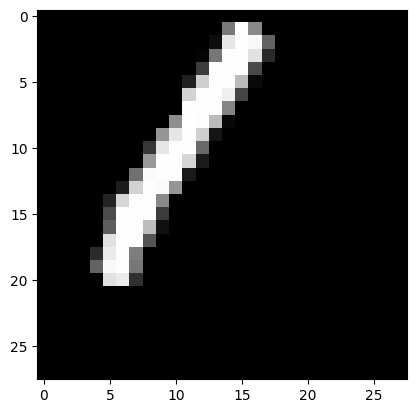

In [6]:
i = 123
img = trainX[i] 
print(trainY[i])
plt.imshow(shift_image(img, -5, -5), cmap=plt.get_cmap('gray'))

In [7]:
trainX.shape

(284559, 28, 28, 1)

In [8]:
cnn = Sequential([
    Conv2D(filters=25, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)), 
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

2024-01-17 11:13:04.519047: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-17 11:13:04.519078: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-17 11:13:04.519095: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-17 11:13:04.519131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 11:13:04.519151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
cnn.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
cnn.fit(trainX, trainY, epochs=5, shuffle=True)

Epoch 1/5
   1/8899 [..............................] - ETA: 49:31 - loss: 2.3073 - accuracy: 0.0000e+00

2024-01-15 09:15:38.815533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8899/8899 [==============================] - 80s 9ms/step - loss: 0.5139 - accuracy: 0.8324
Epoch 2/5
8899/8899 [==============================] - 79s 9ms/step - loss: 0.2040 - accuracy: 0.9348
Epoch 3/5
8899/8899 [==============================] - 79s 9ms/step - loss: 0.1665 - accuracy: 0.9472
Epoch 4/5
8899/8899 [==============================] - 80s 9ms/step - loss: 0.1576 - accuracy: 0.9505
Epoch 5/5
8899/8899 [==============================] - 81s 9ms/step - loss: 0.1917 - accuracy: 0.9440


In [11]:
cnn.save("model.keras")

In [12]:
outputs = cnn.predict(trainX)

  65/8899 [..............................] - ETA: 21s

2024-01-15 09:22:36.323478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8899/8899 [==============================] - 22s 2ms/step


In [13]:
cnn.evaluate(testX, testY)

 11/313 [>.............................] - ETA: 1s - loss: 0.1737 - accuracy: 0.9489 

2024-01-15 09:23:21.994078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 0.2122 - accuracy: 0.9466


[0.21223607659339905, 0.9466000199317932]

In [52]:
eps = 0.8
epsI = eps * np.eye(28)
S = S_orig + epsI

1/1 [==============================] - 0s 18ms/step
1
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 12ms/step
7
1/1 [==============================] - 0s 12ms/step
7
1/1 [==============================] - 0s 12ms/step
7


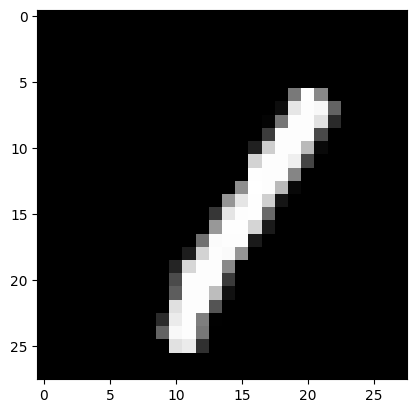

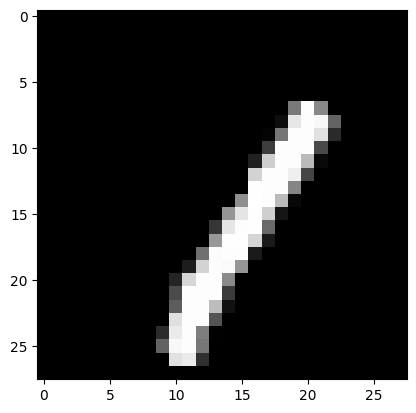

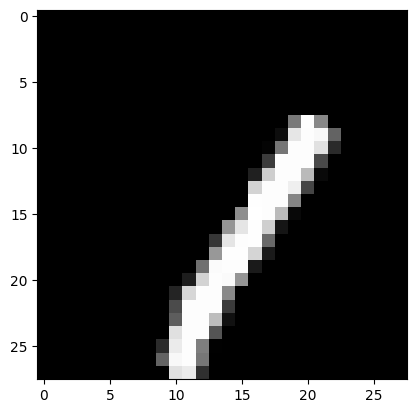

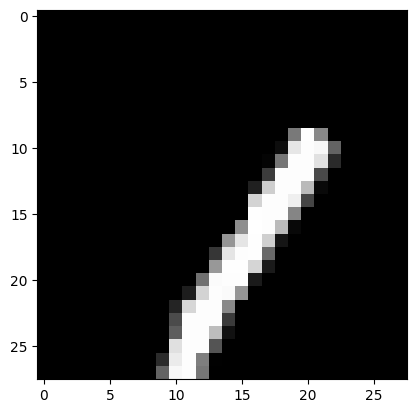

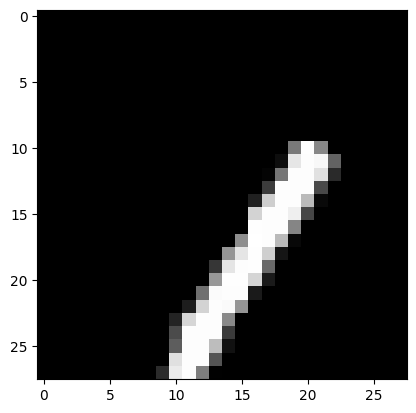

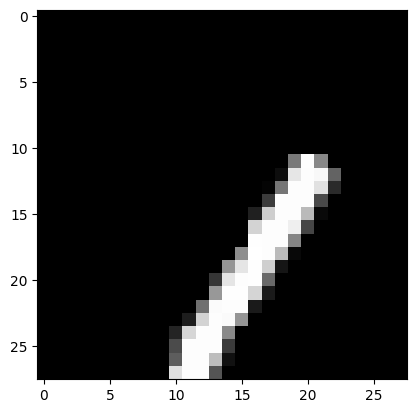

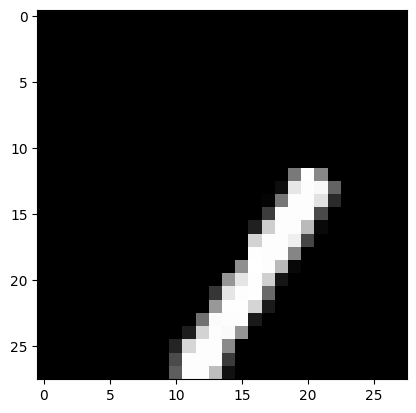

In [28]:
shifts = [None for _ in range(7)]
for i in range(7):
    b = np.reshape(img, (28, 28,))
    for j in range(i):
        b = np.dot(S_orig, b)
    shifts[i] = b
    print(np.argmax(cnn.predict(np.array([np.reshape(b, (28, 28, 1))]))))
    plt.figure()
    plt.imshow(b, cmap=plt.get_cmap('gray'))

In [53]:
L = scipy.linalg.logm(S)

In [19]:
def flow(image, t):
    plt.figure()
    image_ = np.reshape(image, (28, 28,))
    S_to_the_t = scipy.linalg.expm(t * L)
    image_ = np.dot(S_to_the_t, image_)
    plt.imshow(image_, cmap=plt.get_cmap('gray'))
    return image_

# Logarithm Noise

There seems to be a tradeoff between noise and numerical stability. In particular, for small epsilon values, `flow` is only stable at integer values. For larger epsilon values, it is noisy

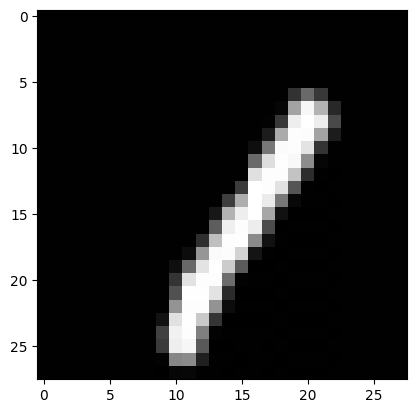

In [55]:
a = flow(img, 1.1)

0
1
2
3
4


/var/folders/g9/5ckk3z5s5vb3t9_yxksst47m0000gn/T/ipykernel_91247/3684391535.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x117223c40> (for post_execute):



KeyboardInterrupt



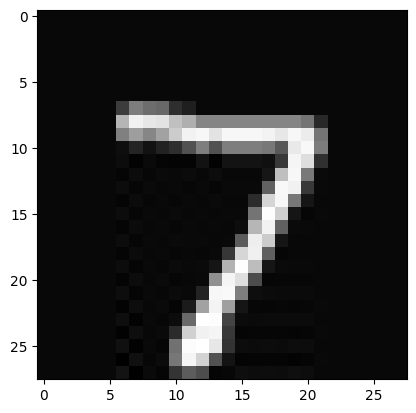

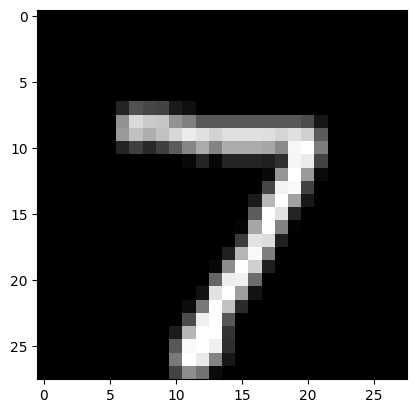

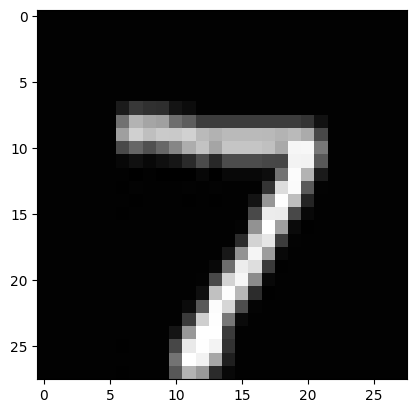

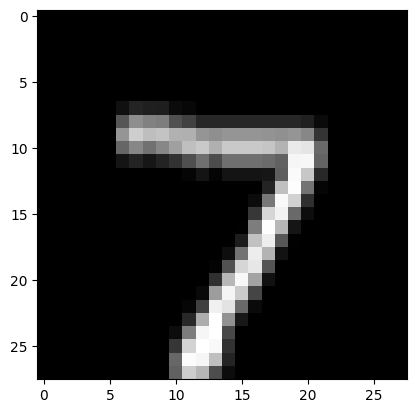

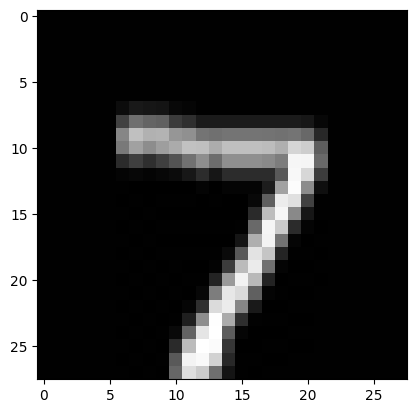

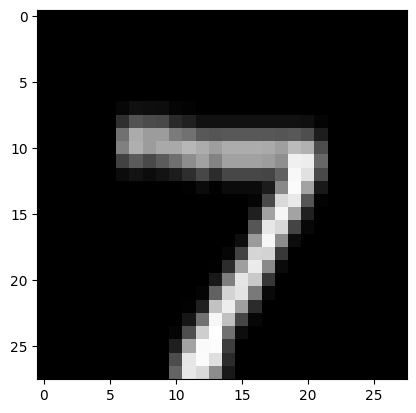

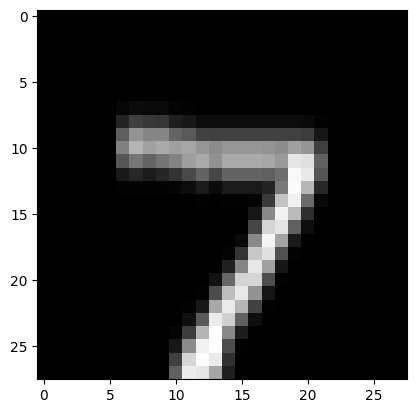

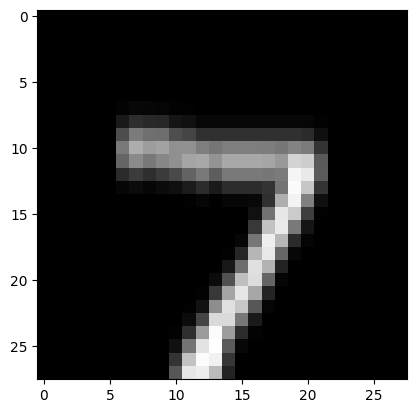

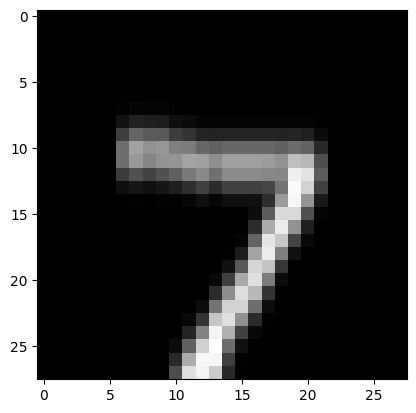

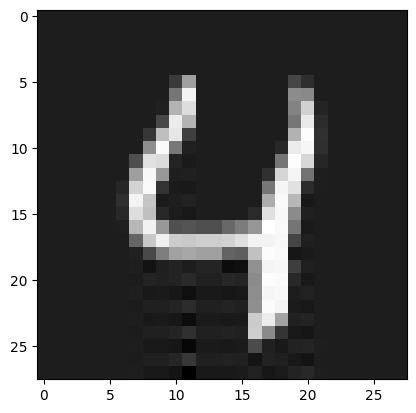

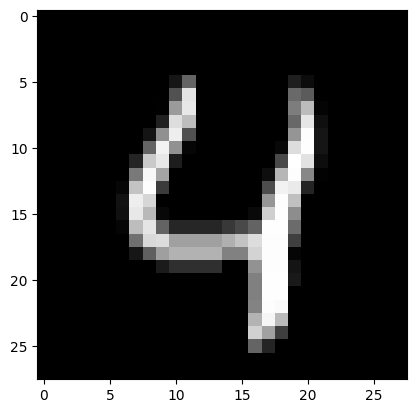

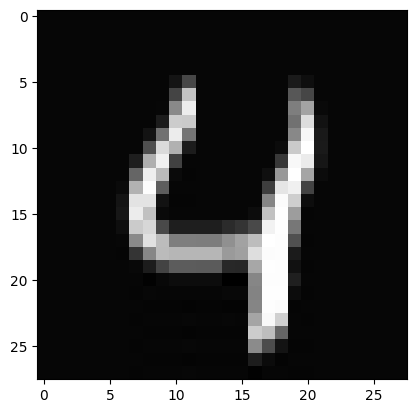

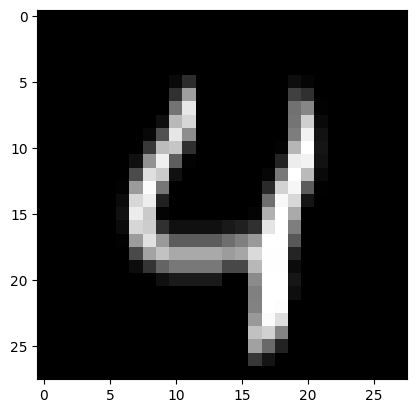

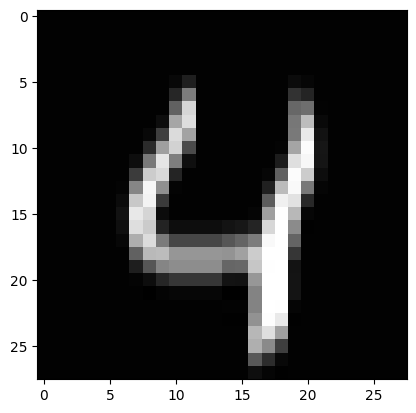

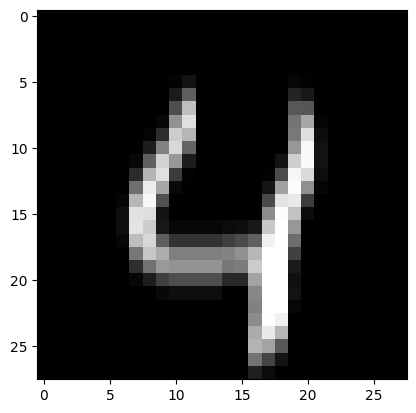

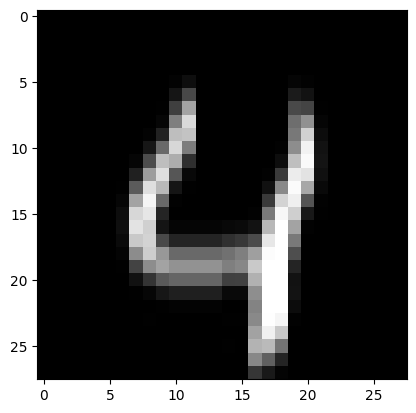

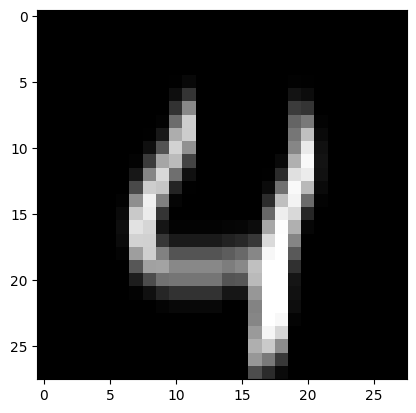

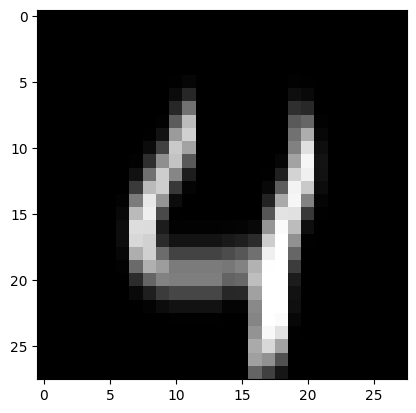

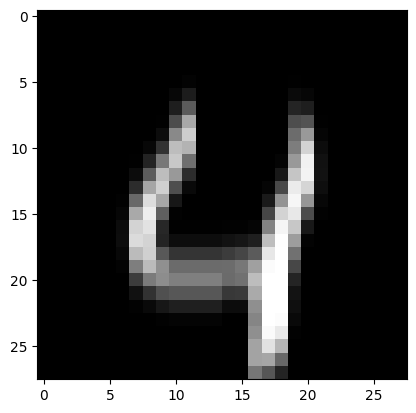

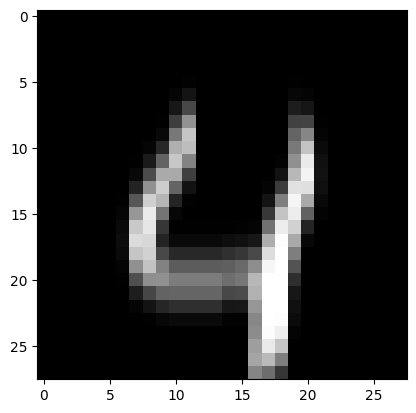

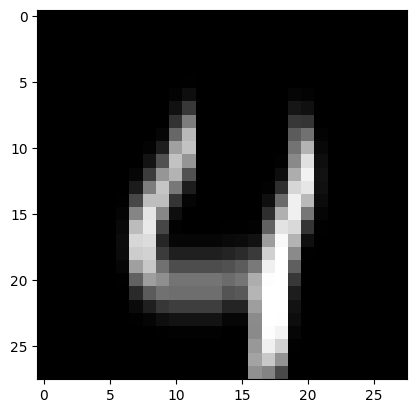

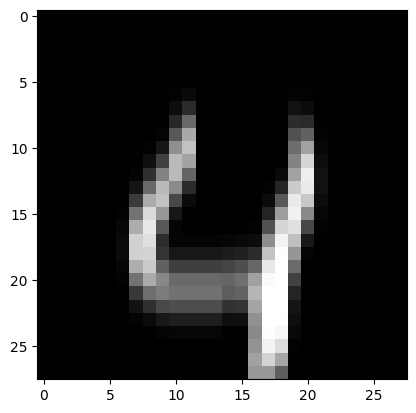

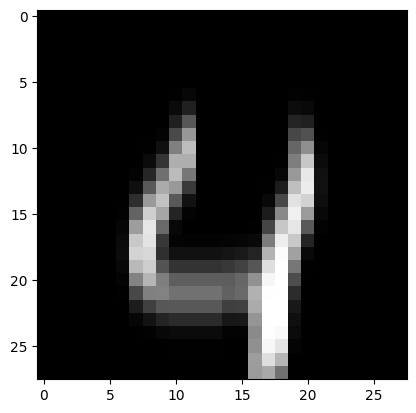

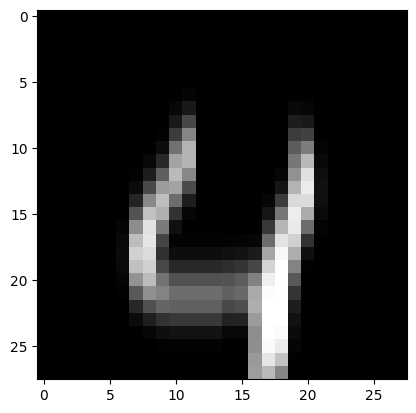

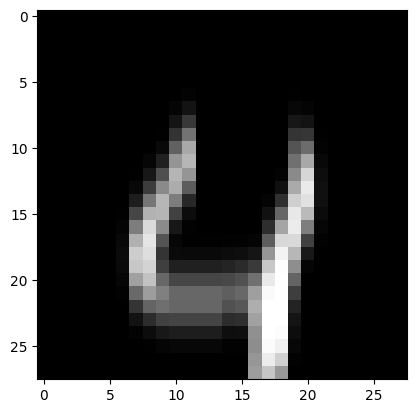

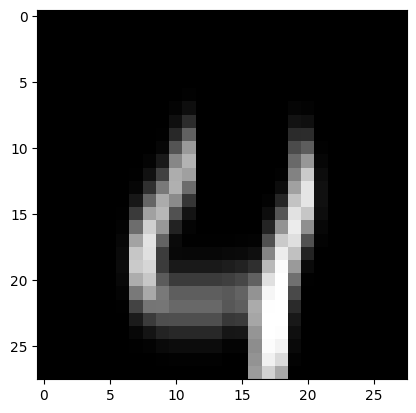

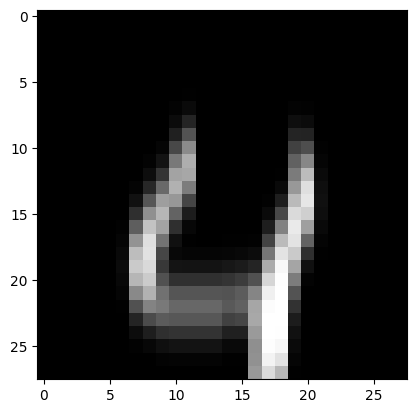

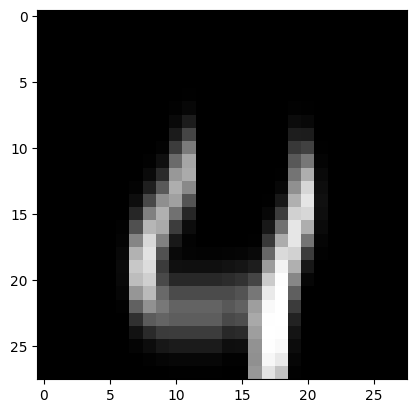

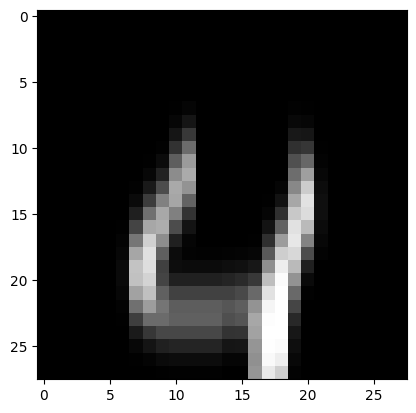

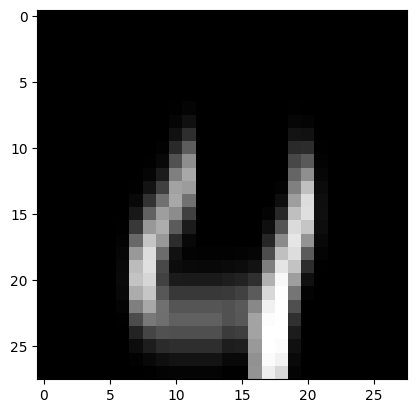

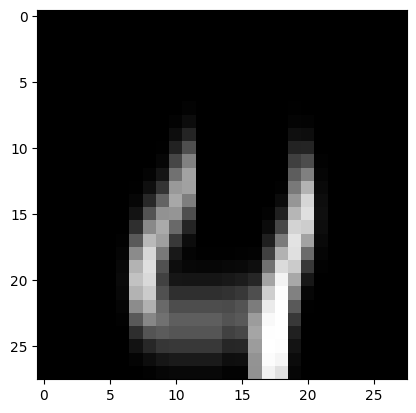

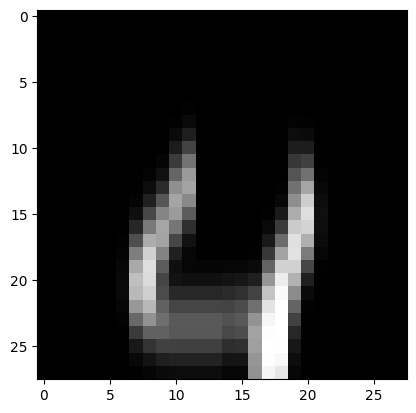

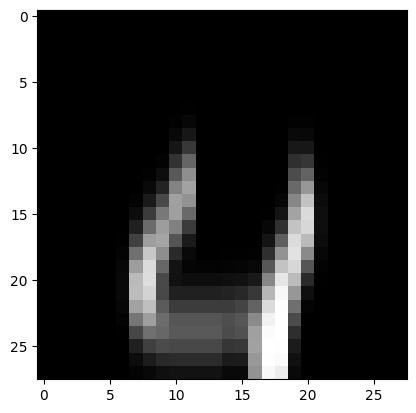

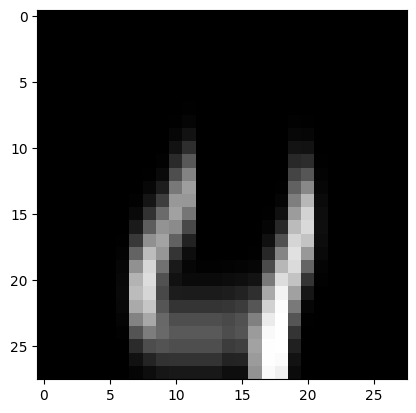

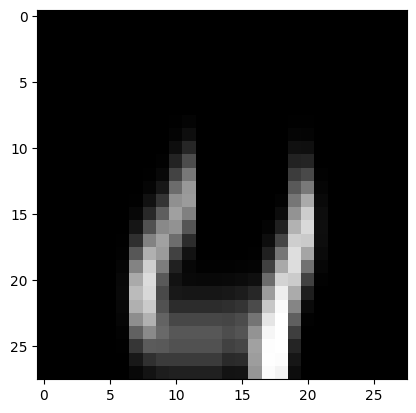

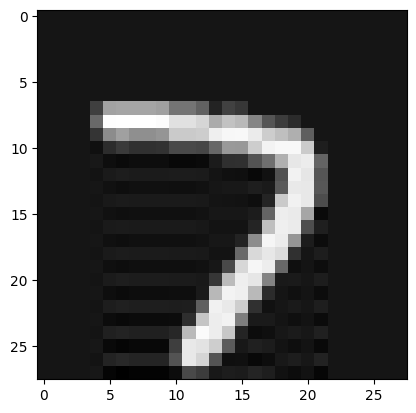

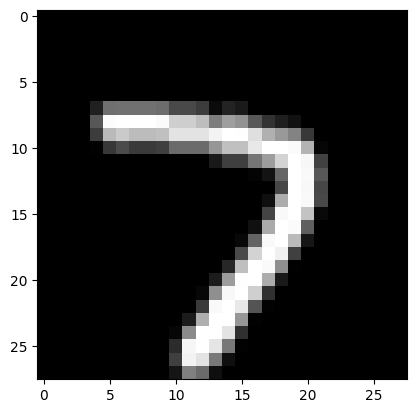

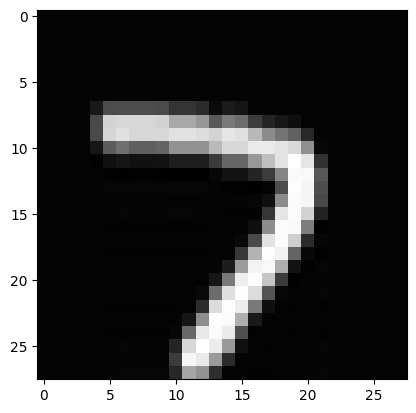

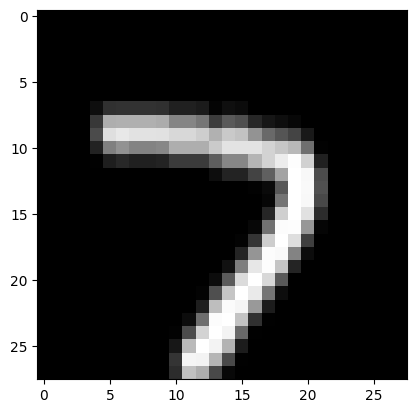

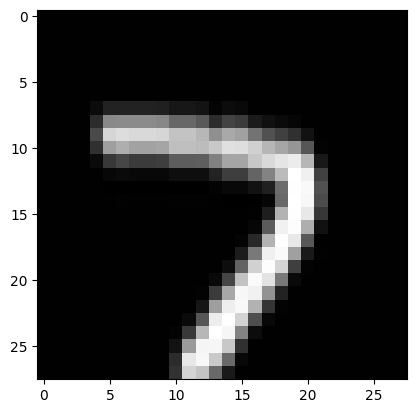

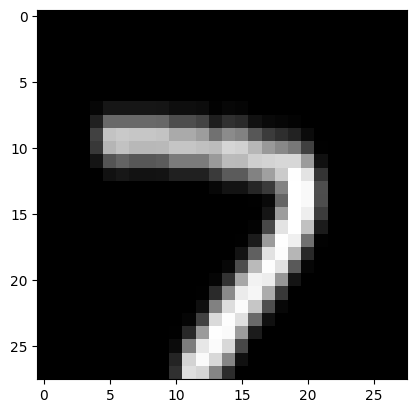

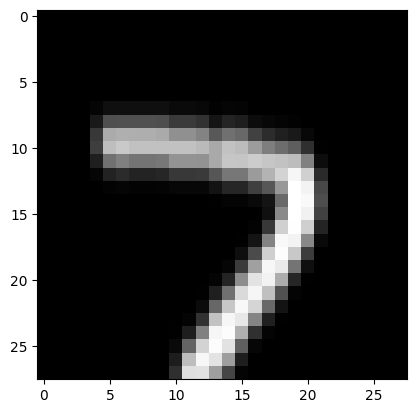

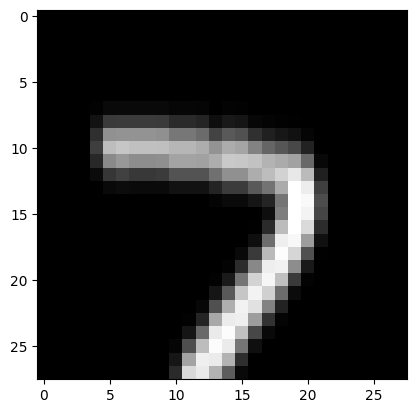

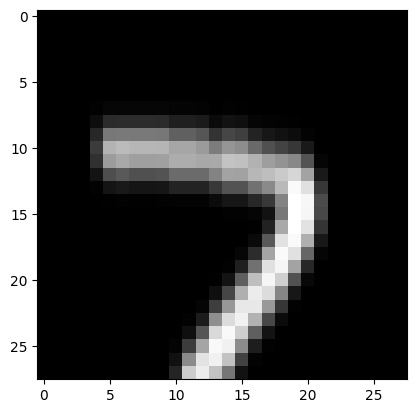

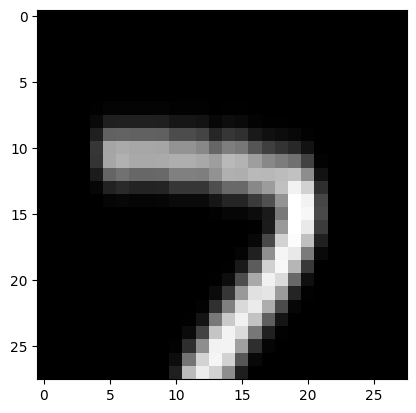

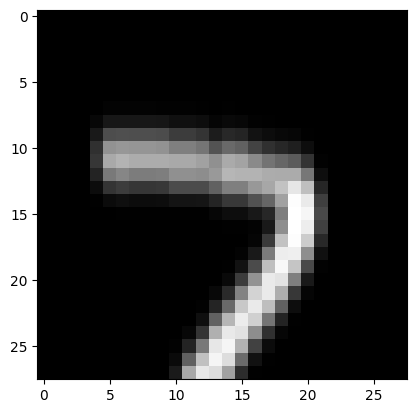

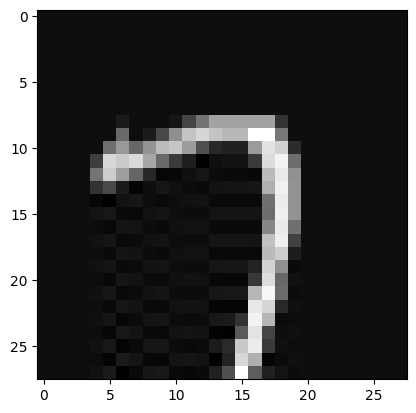

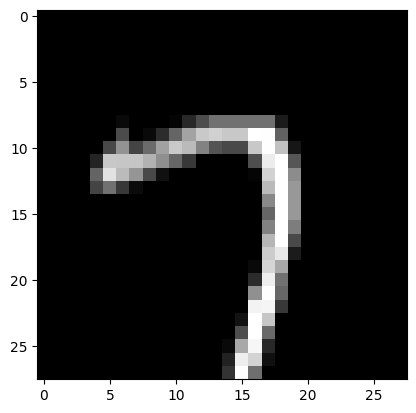

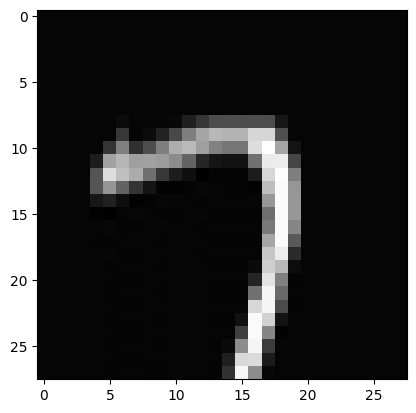

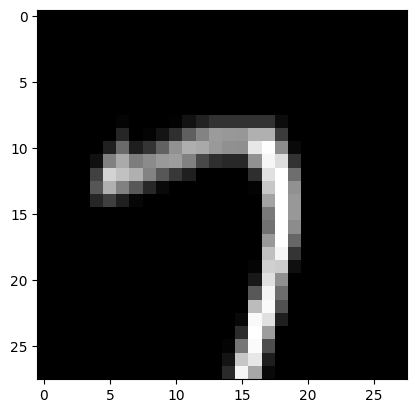

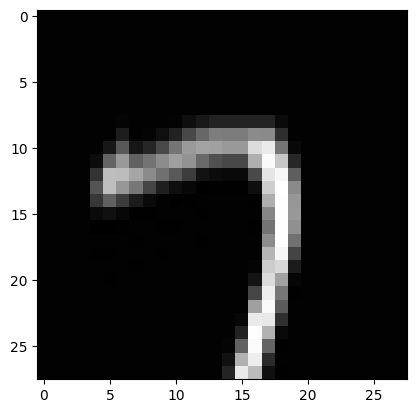

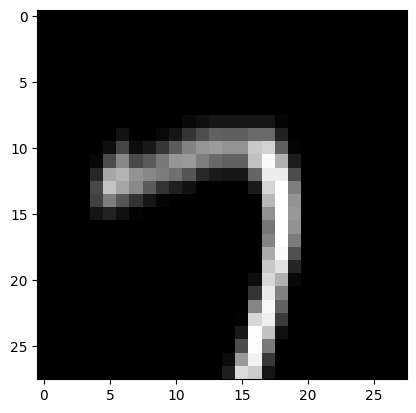

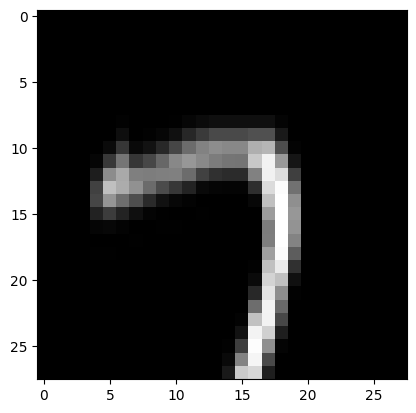

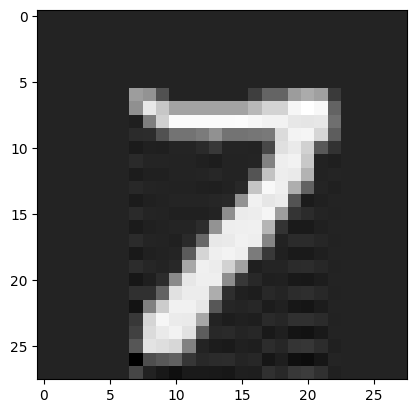

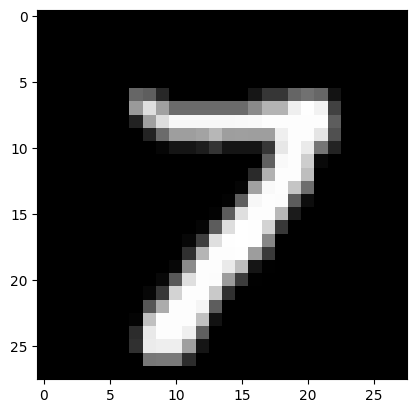

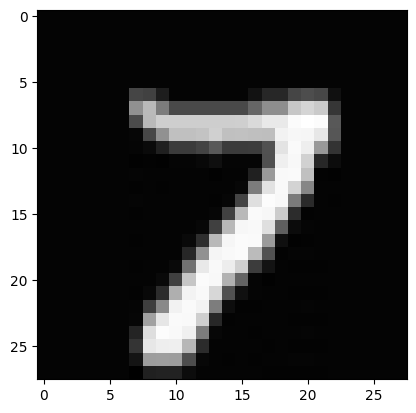

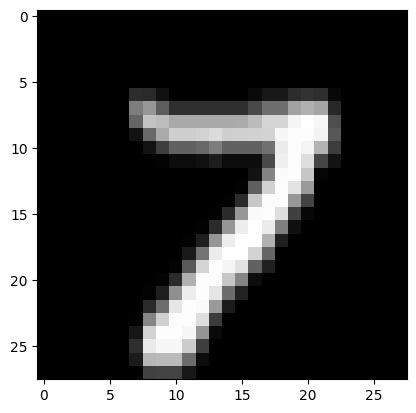

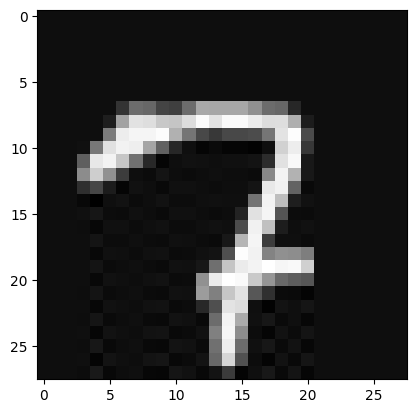

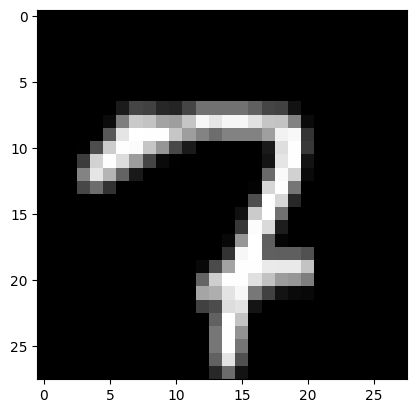

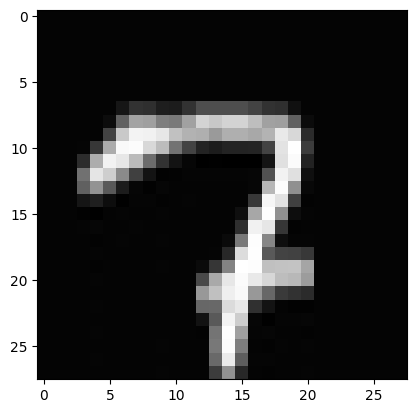

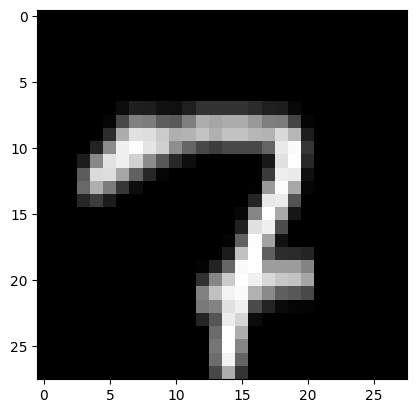

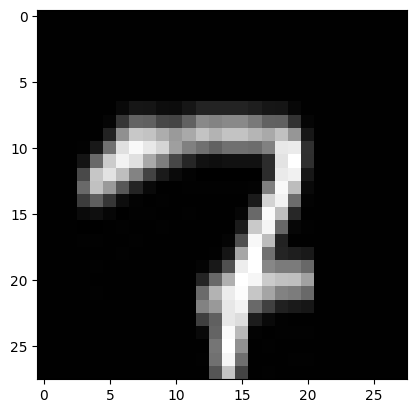

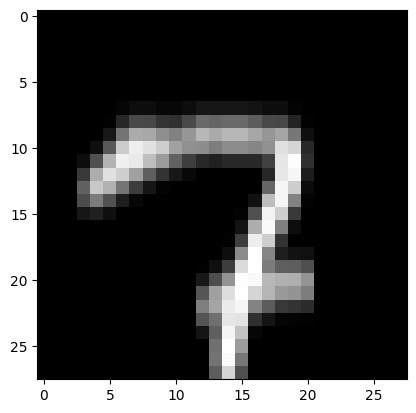

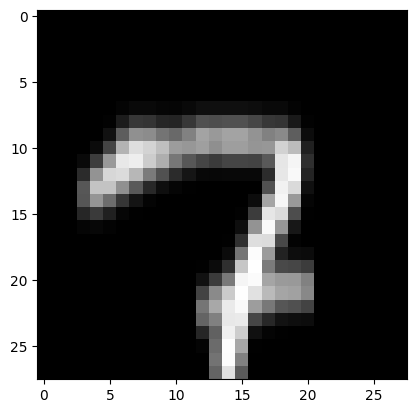

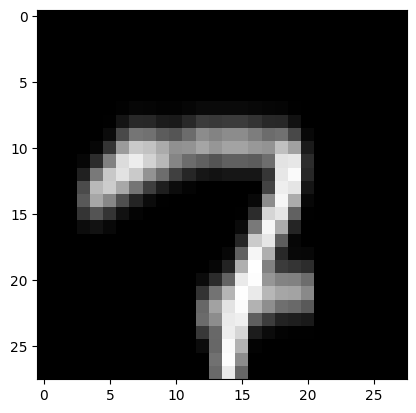

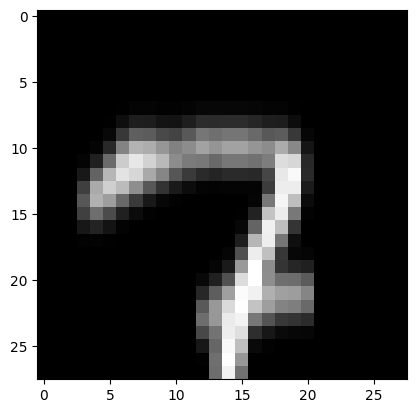

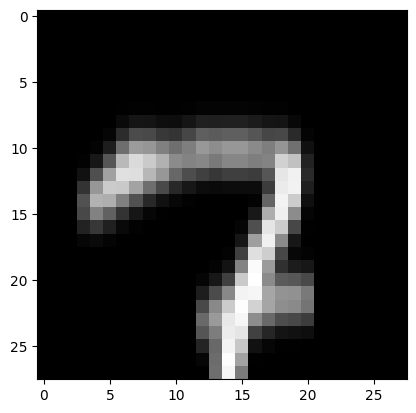

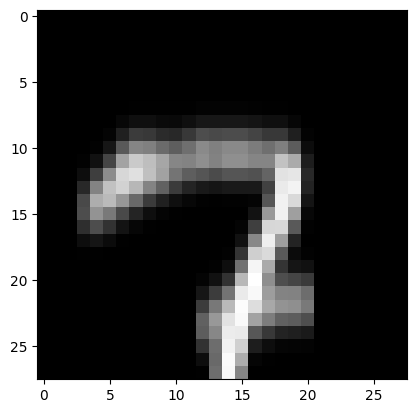

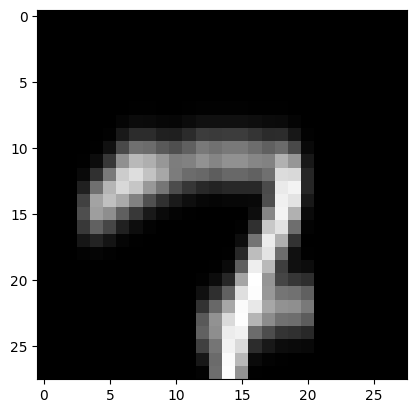

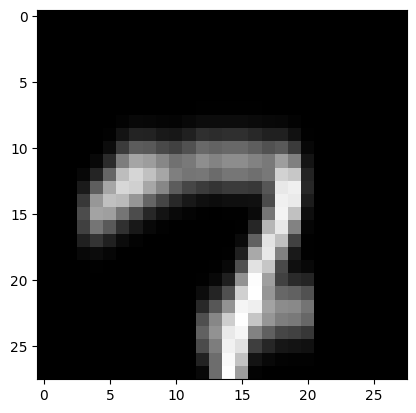

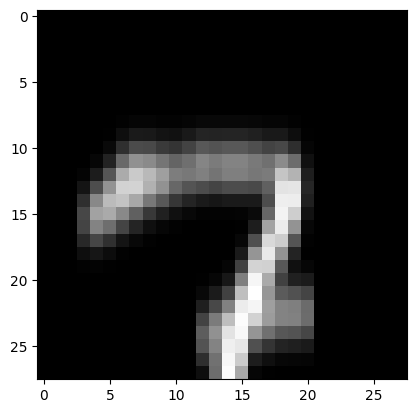

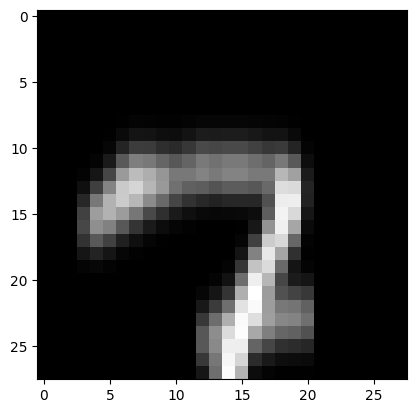

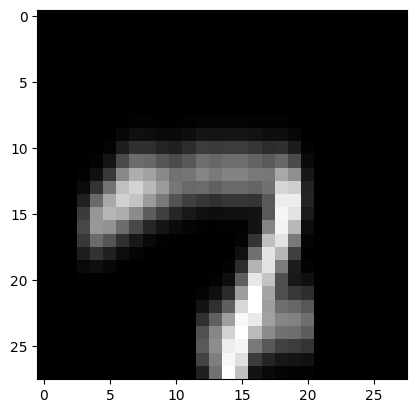

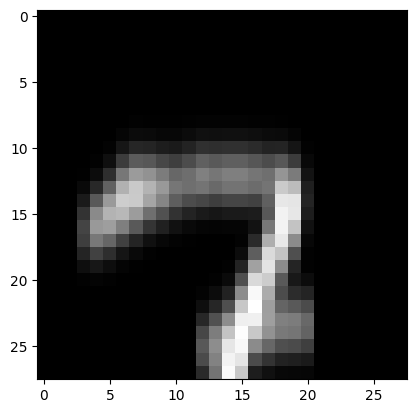

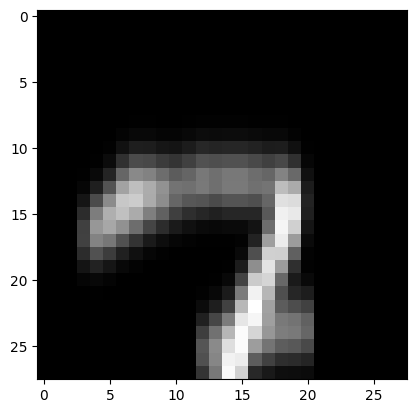

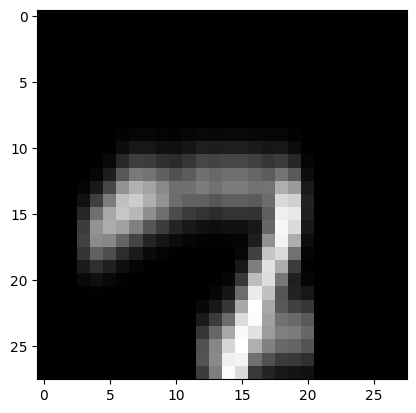

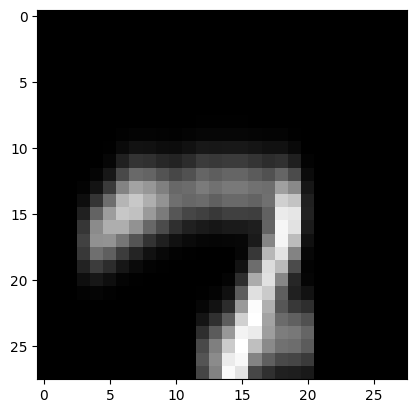

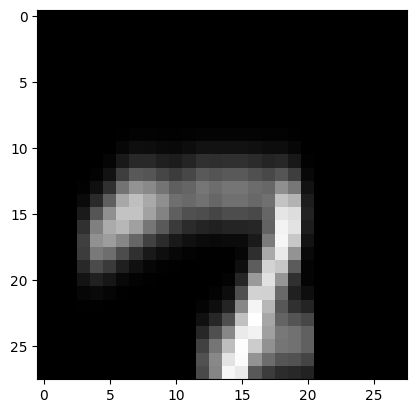

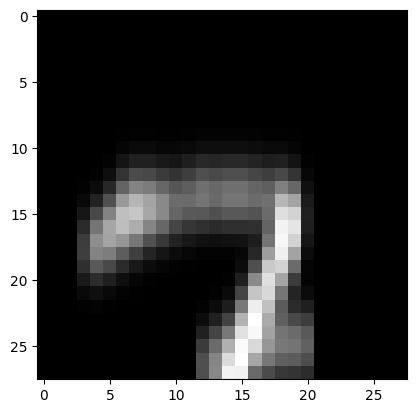

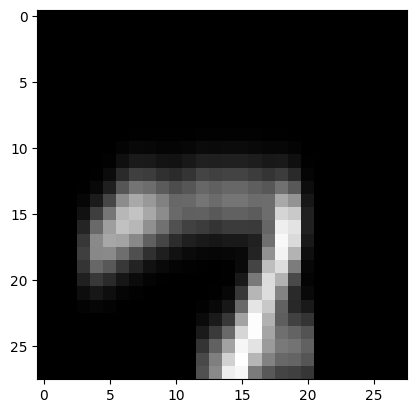

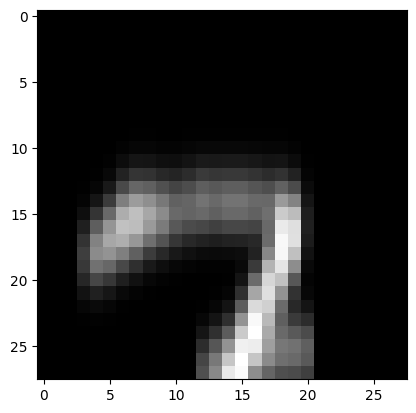

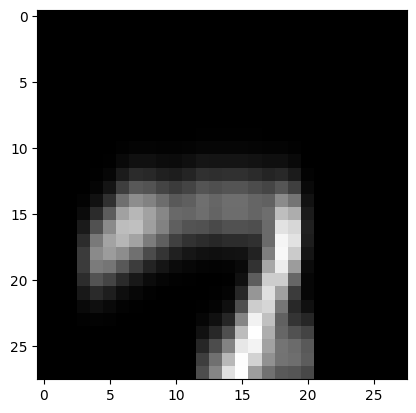

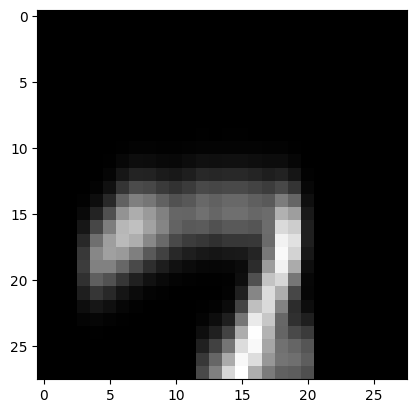

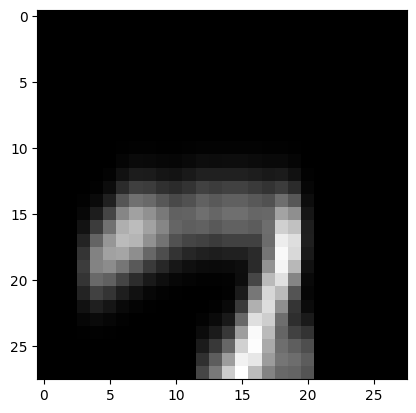

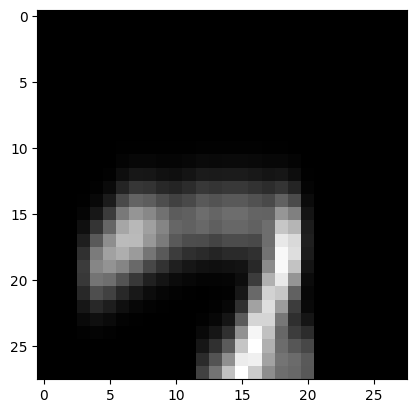

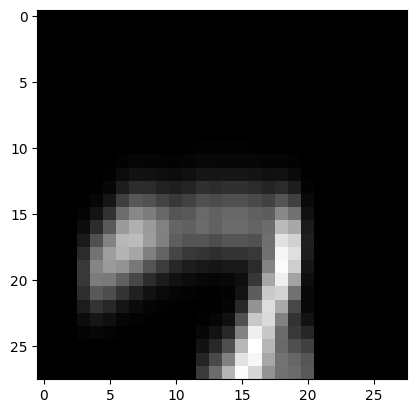

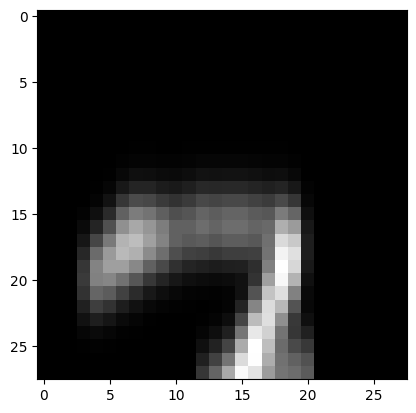

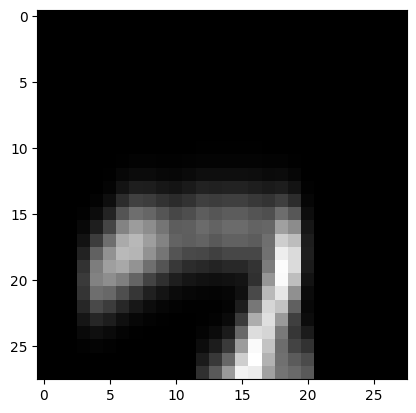

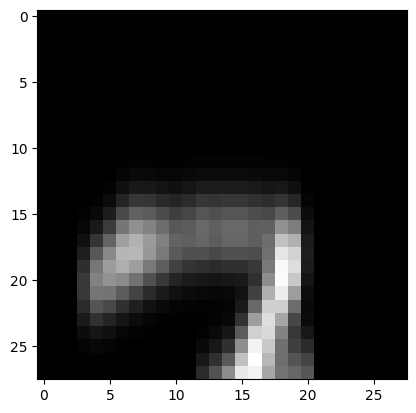

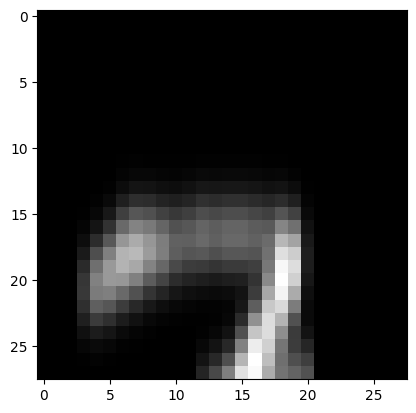

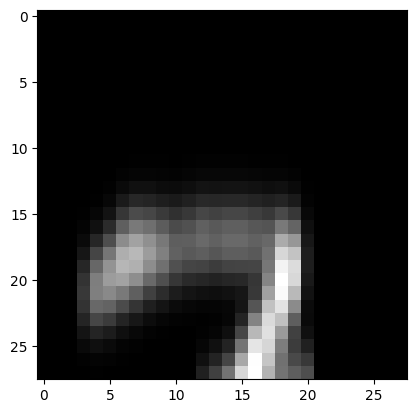

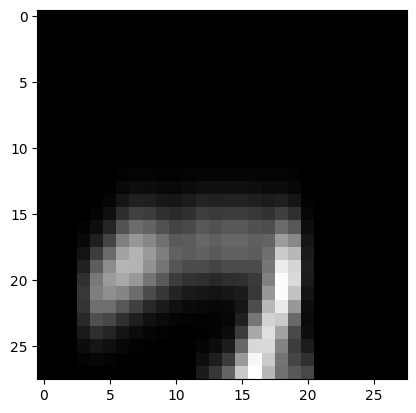

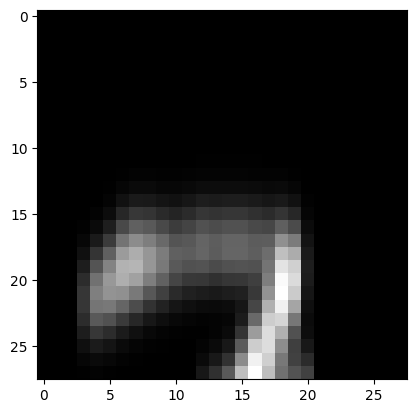

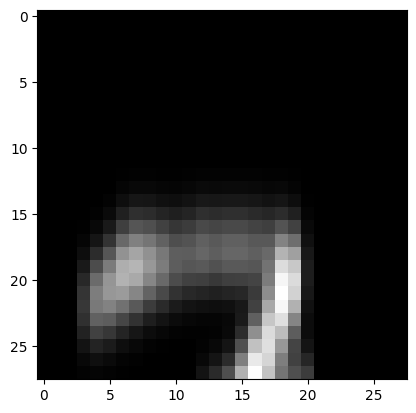

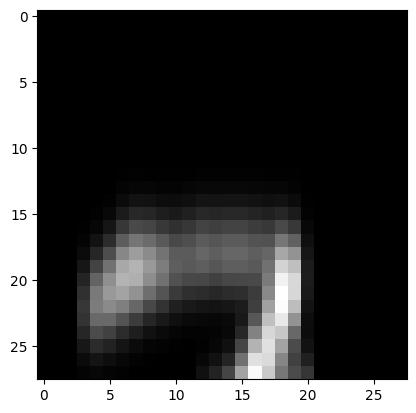

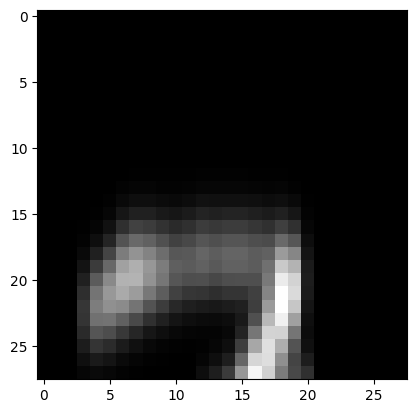

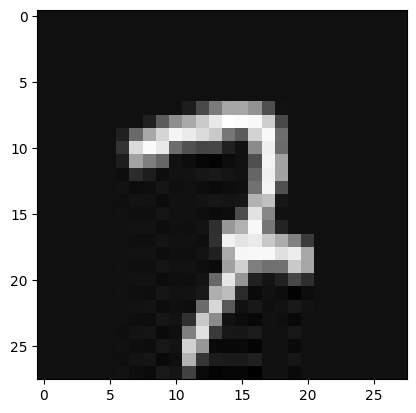

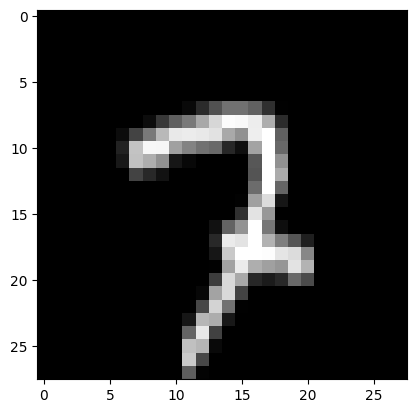

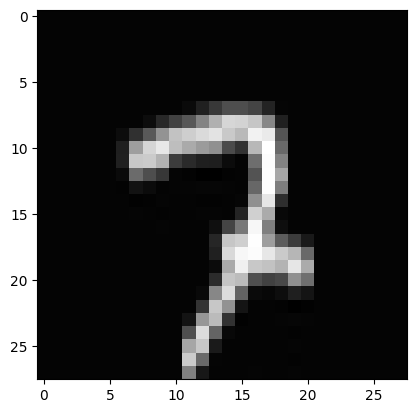

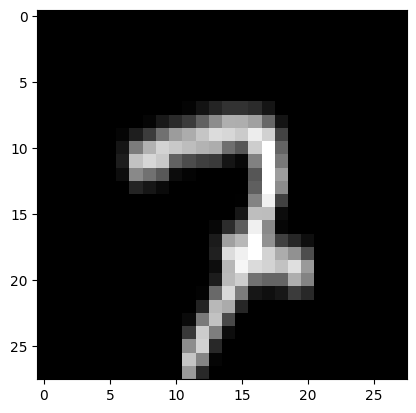

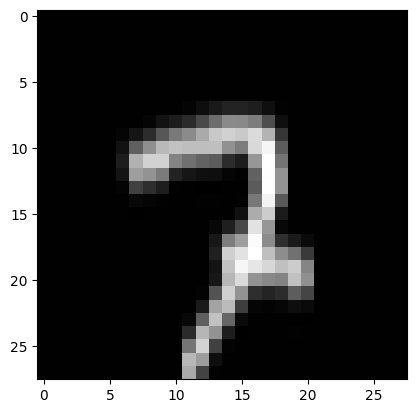

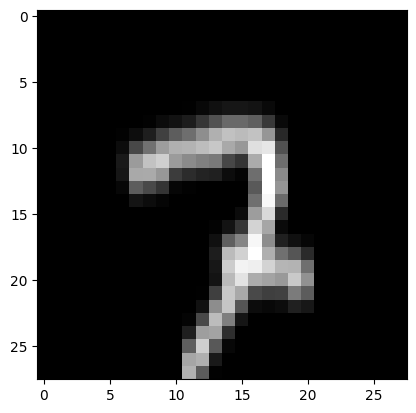

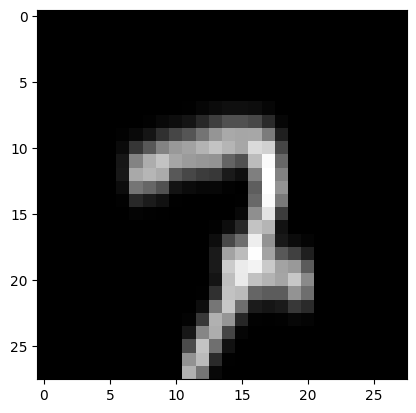

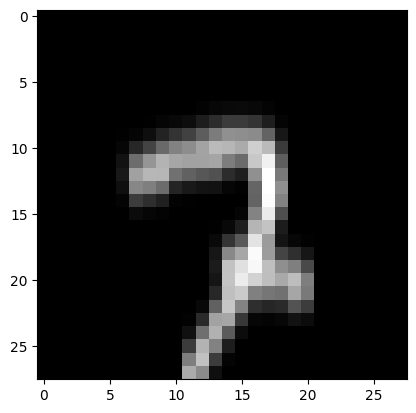

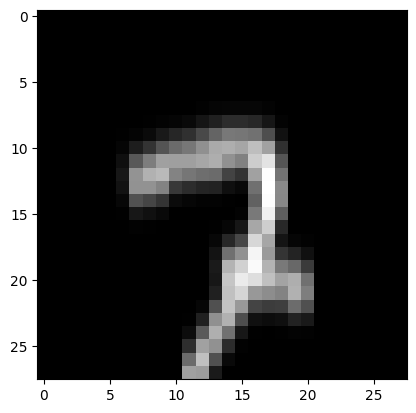

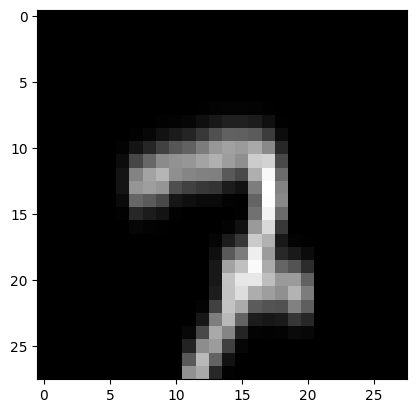

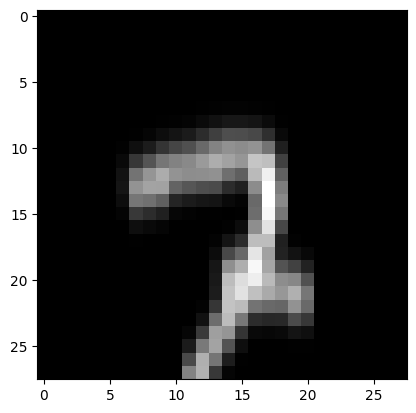

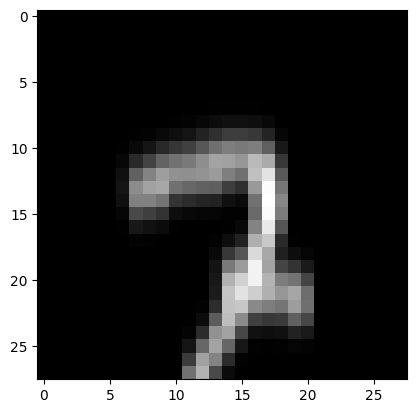

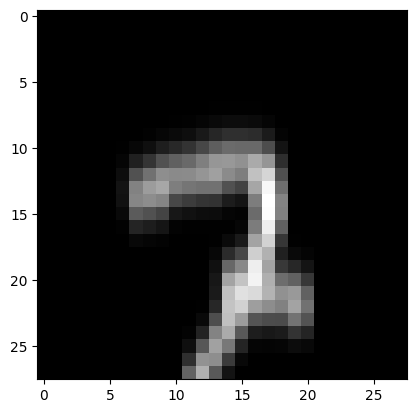

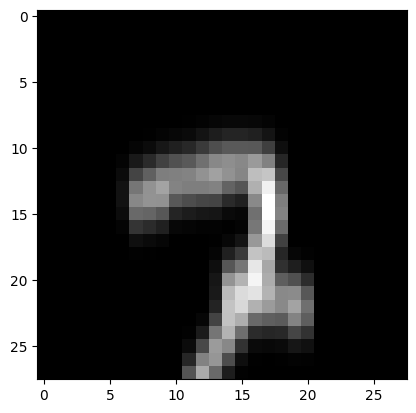

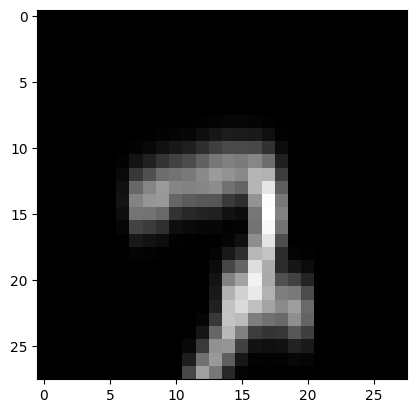

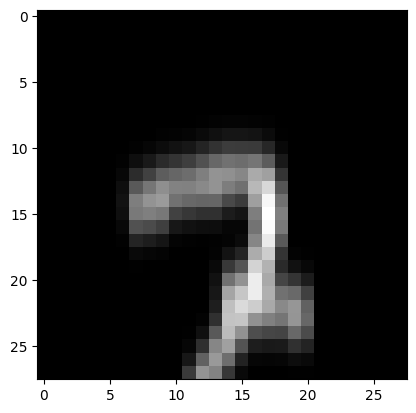

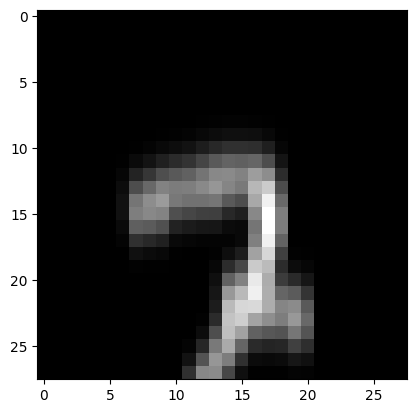

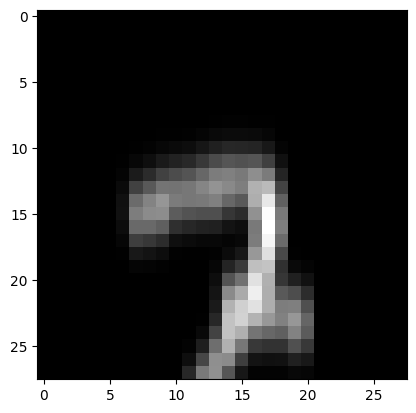

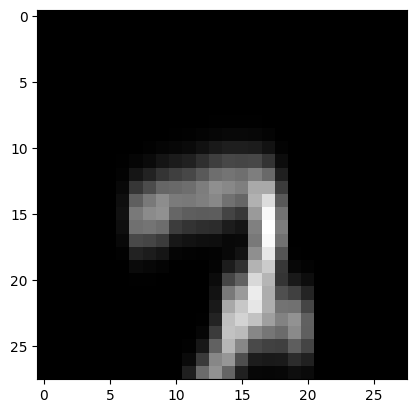

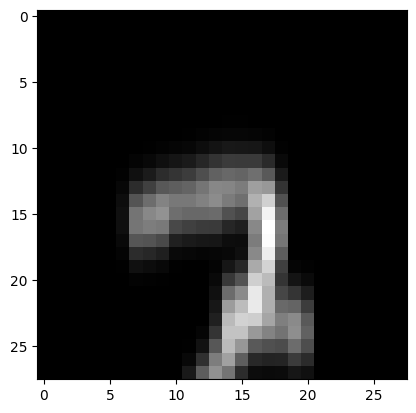

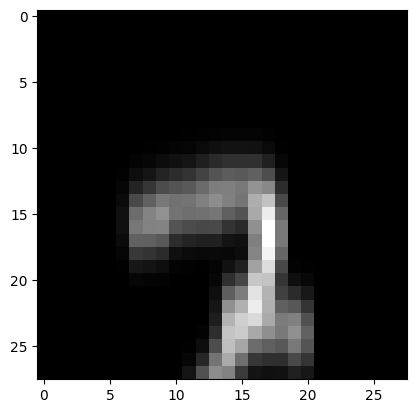

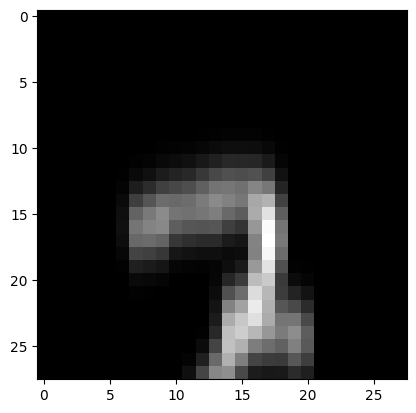

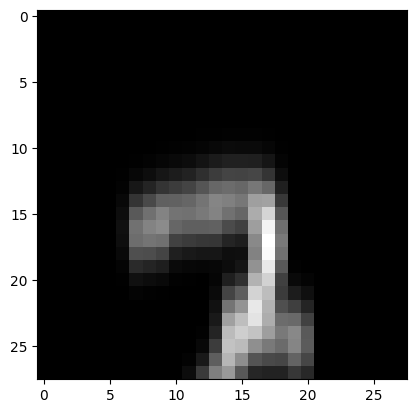

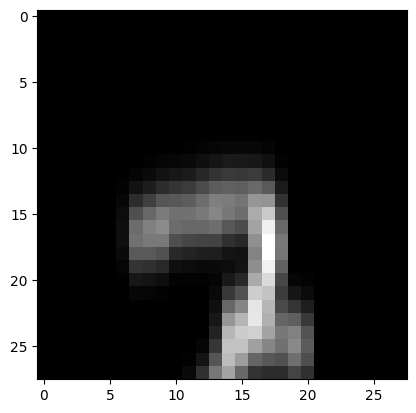

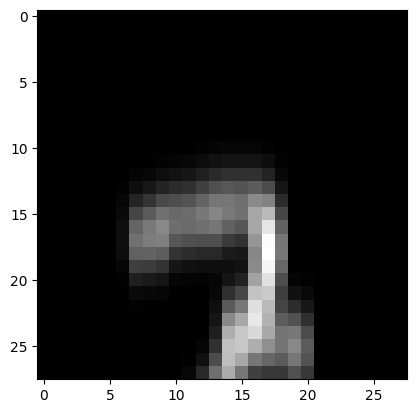

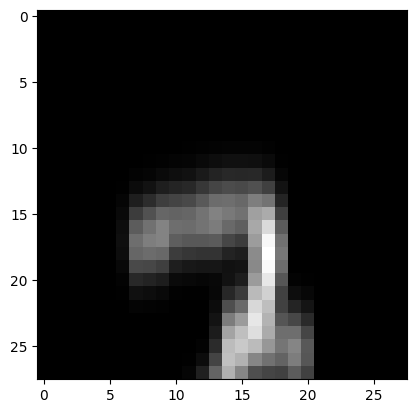

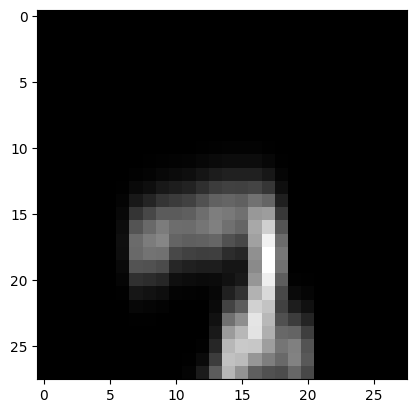

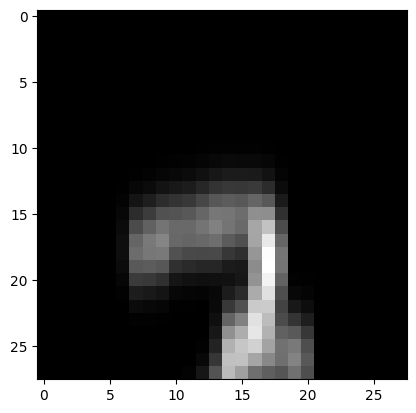

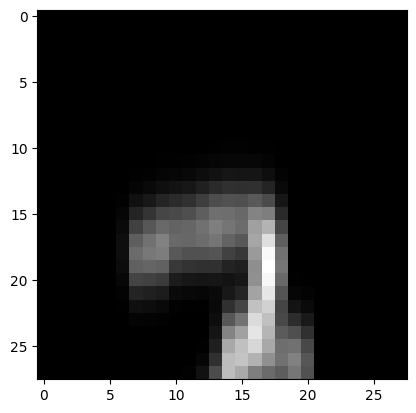

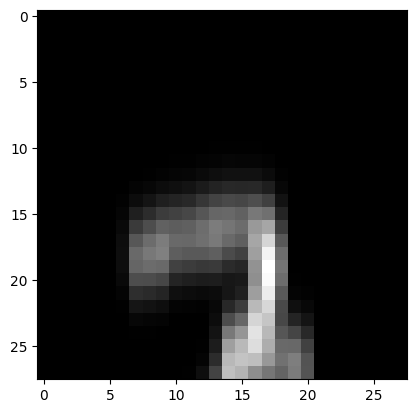

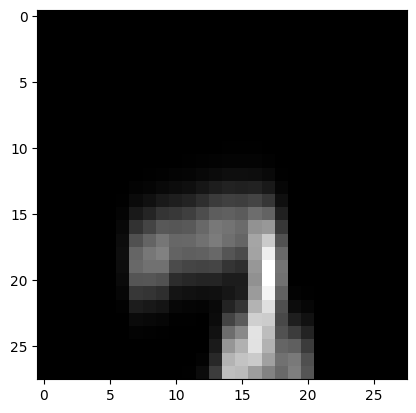

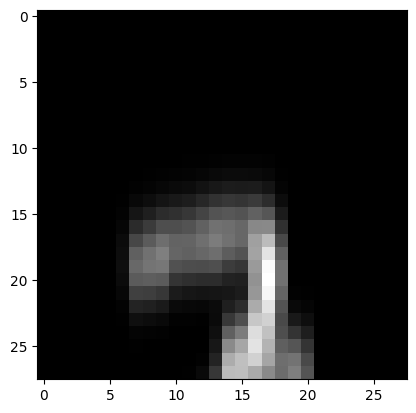

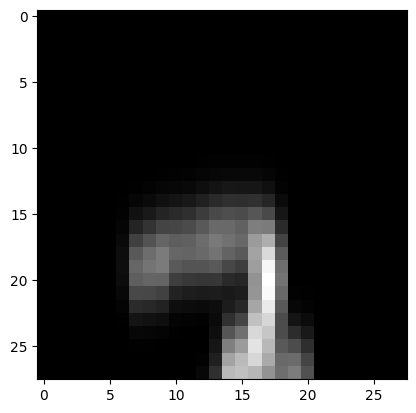

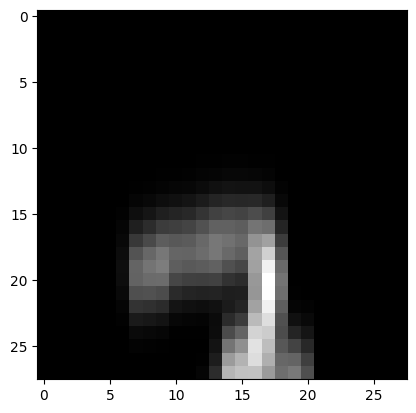

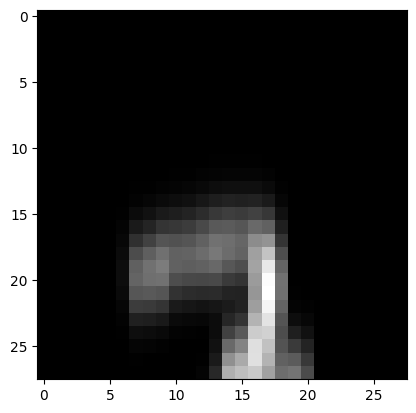

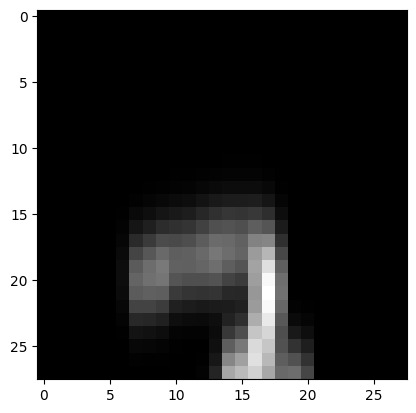

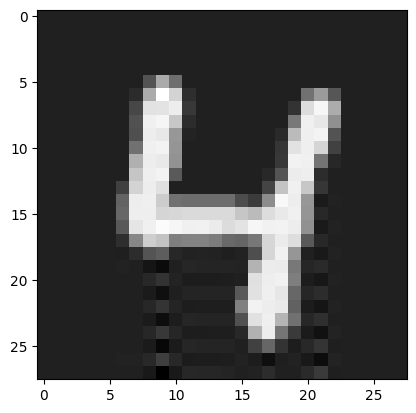

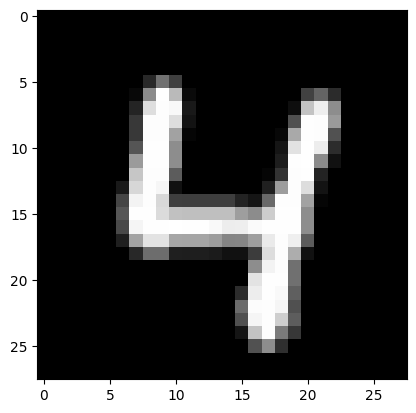

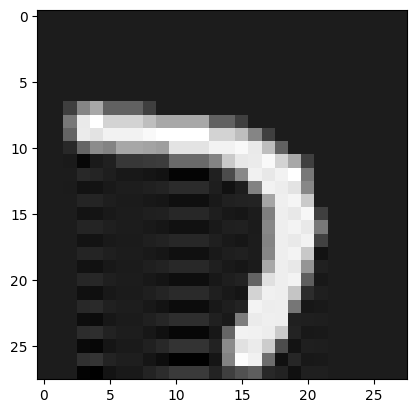

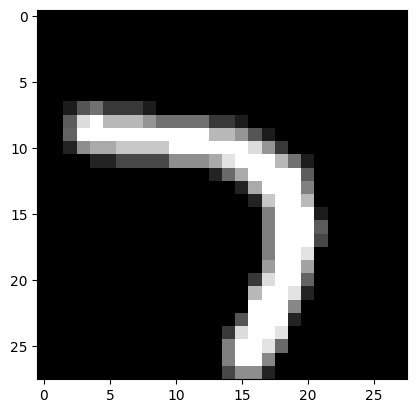

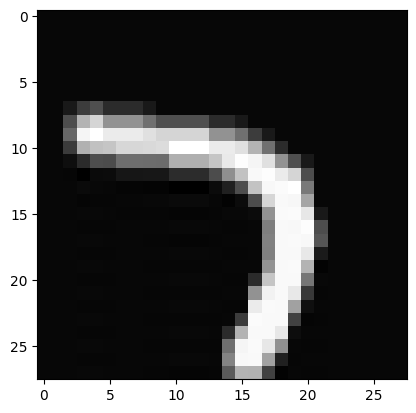

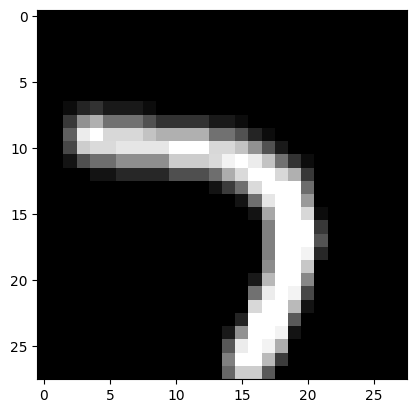

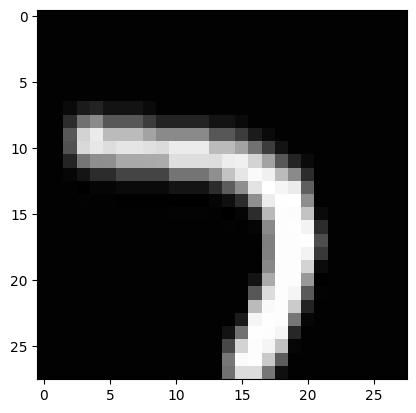

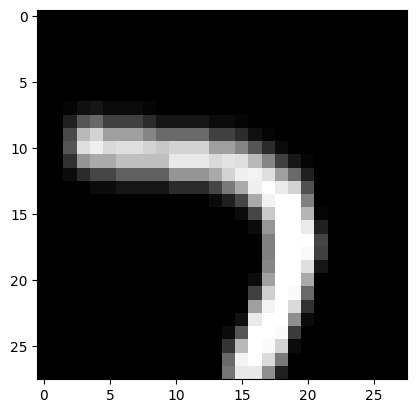

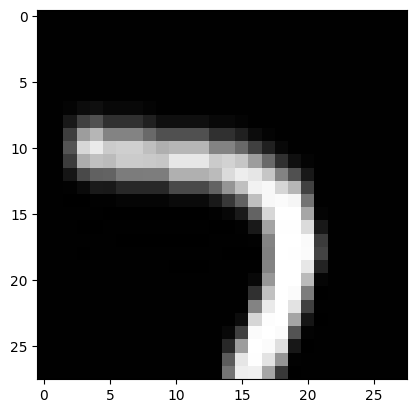

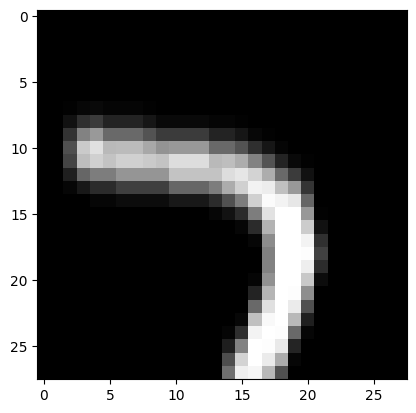

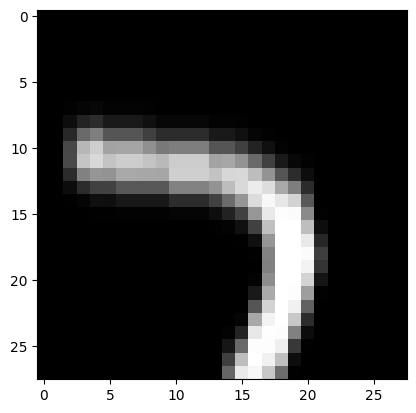

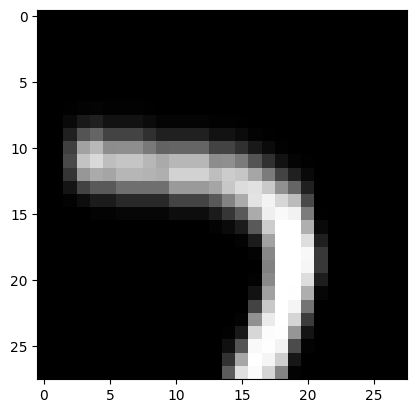

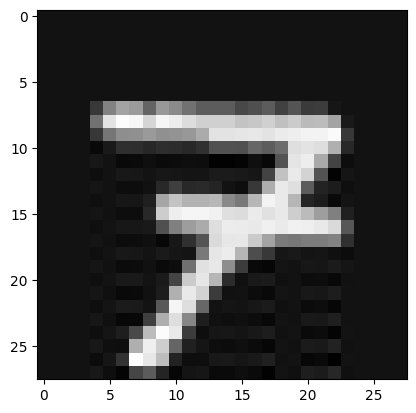

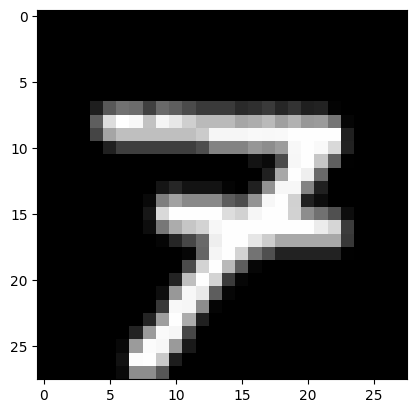

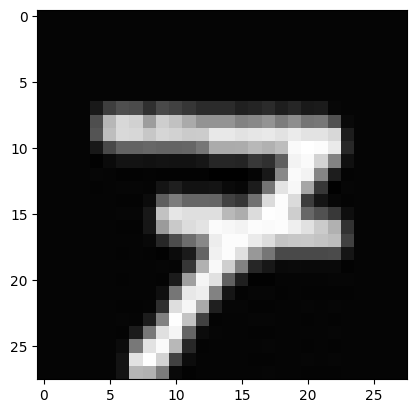

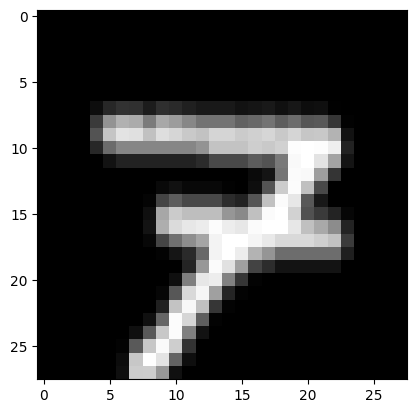

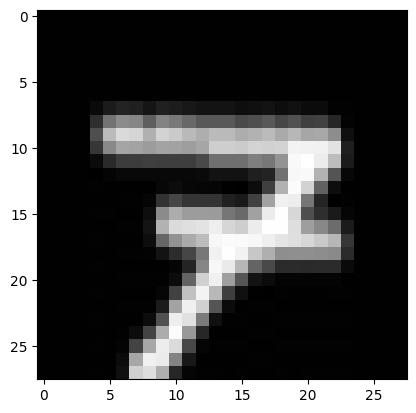

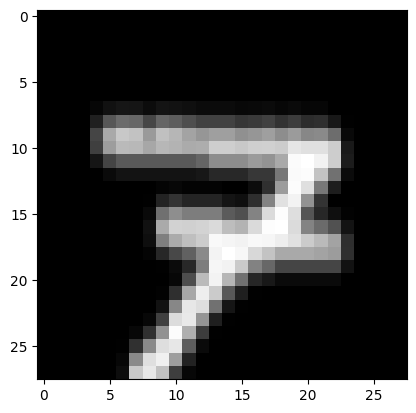

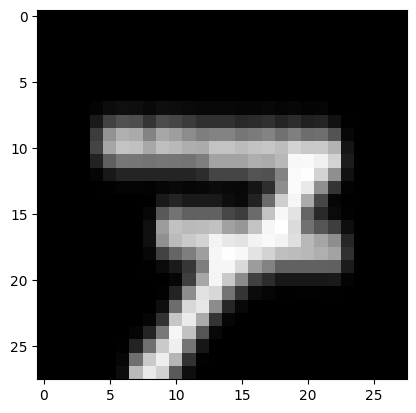

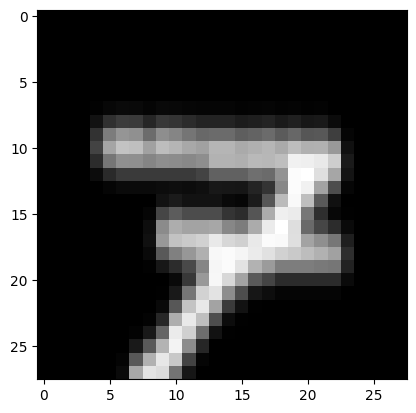

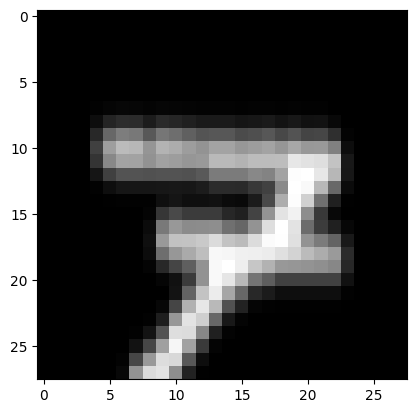

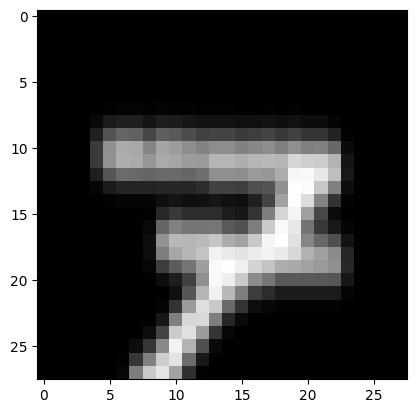

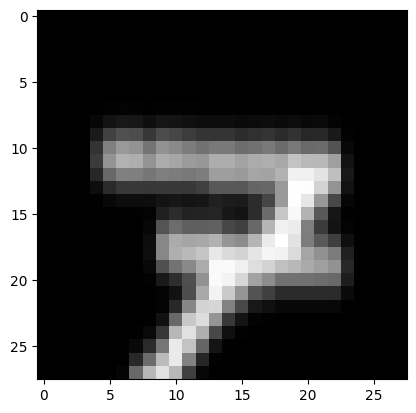

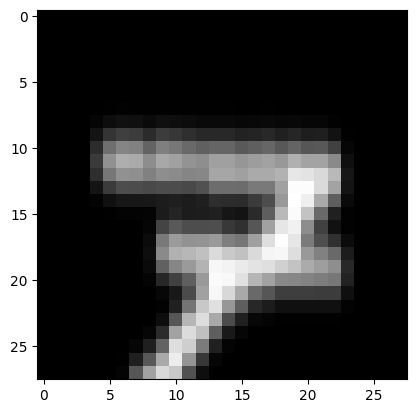

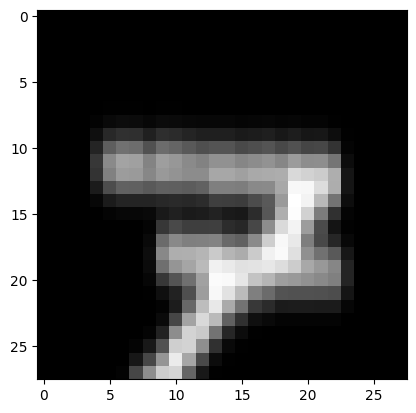

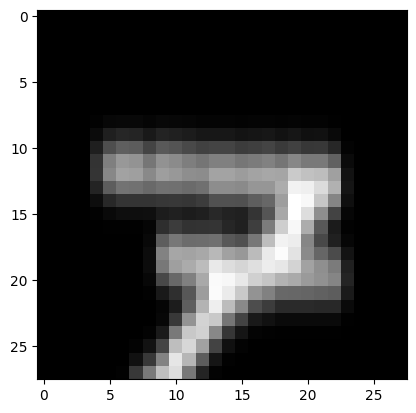

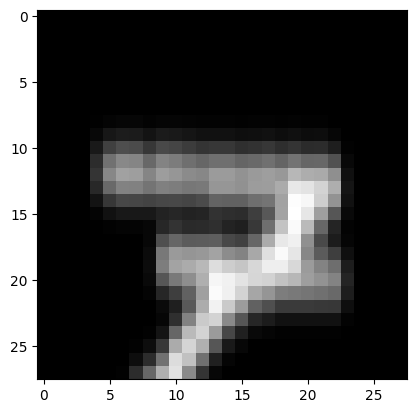

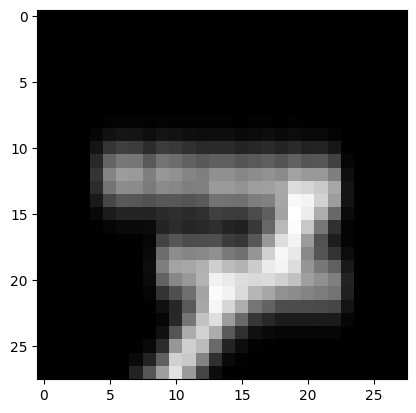

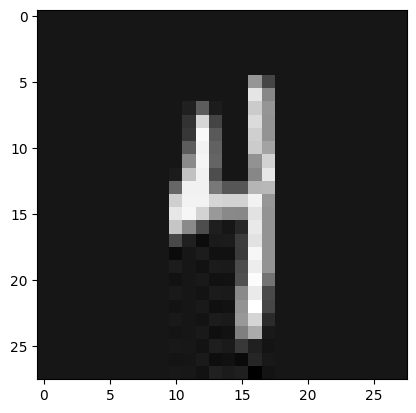

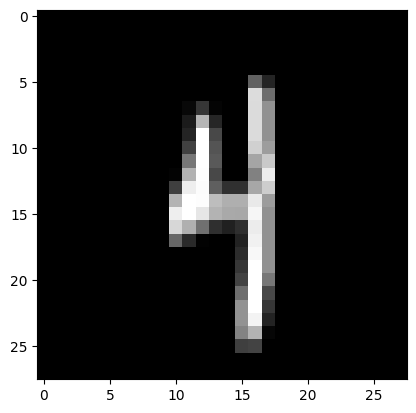

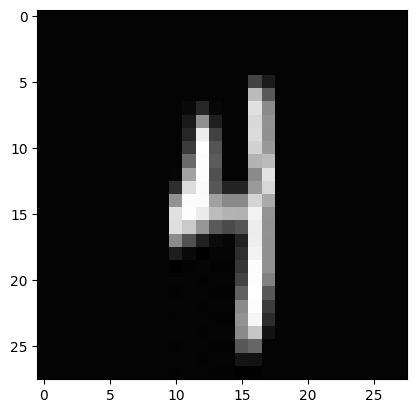

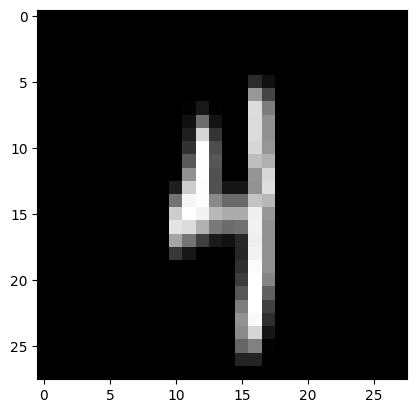

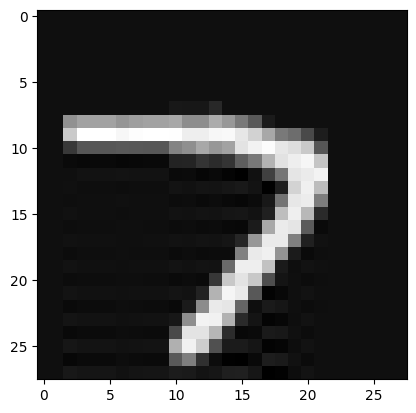

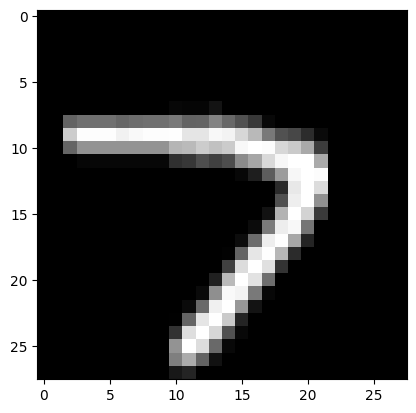

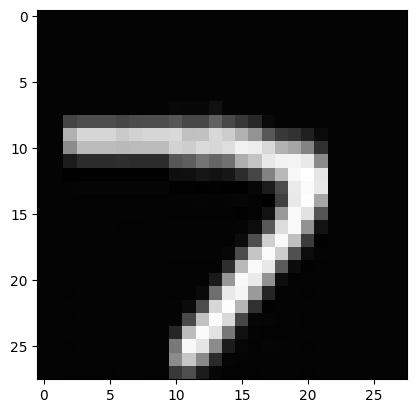

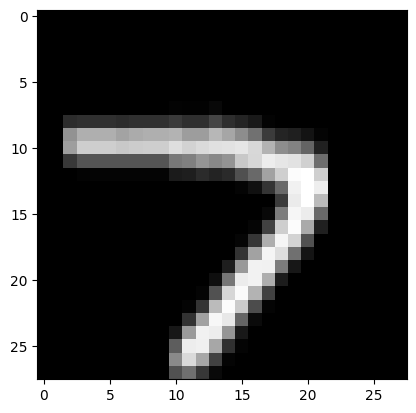

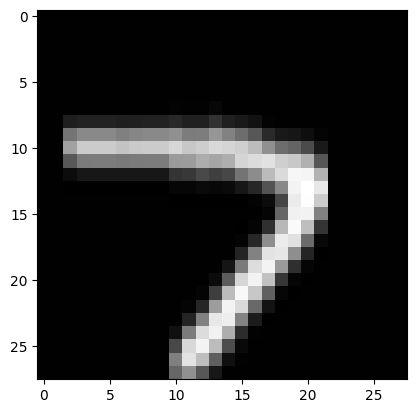

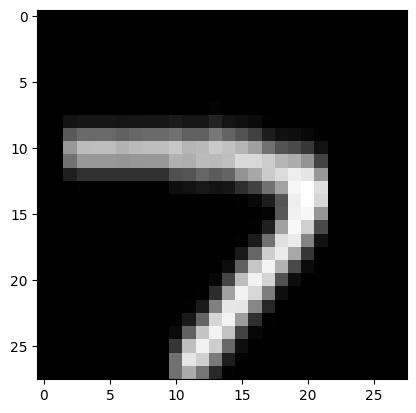

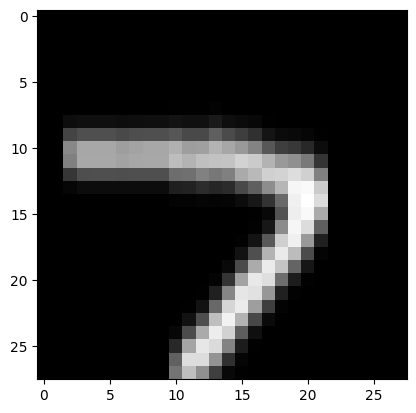

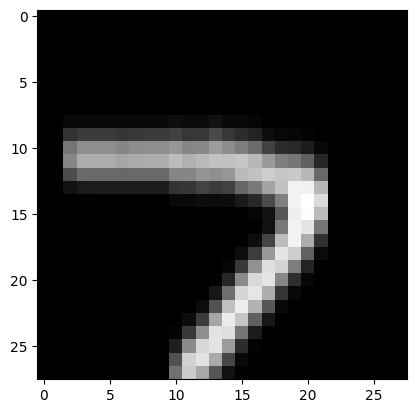

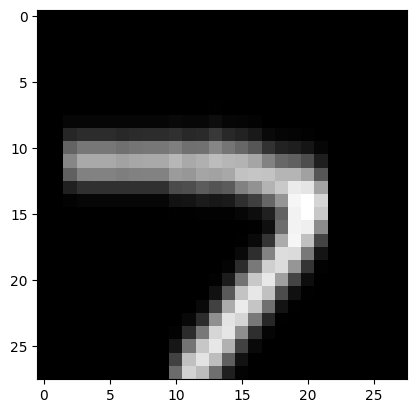

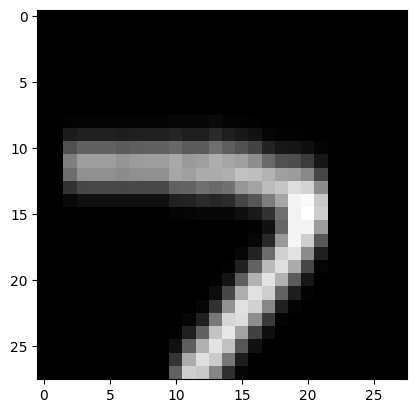

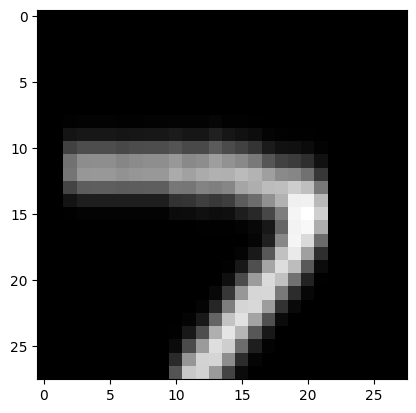

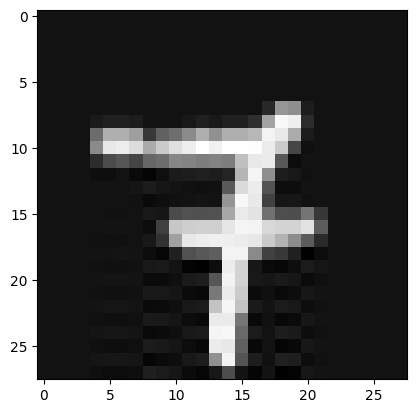

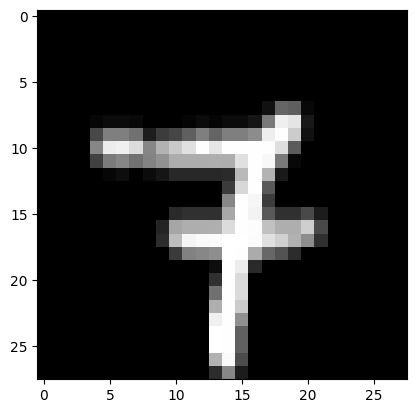

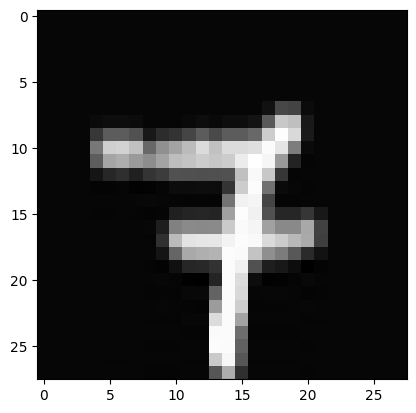

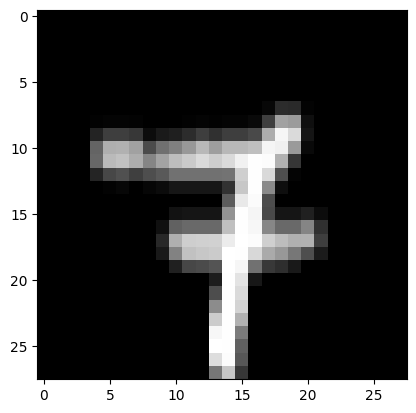

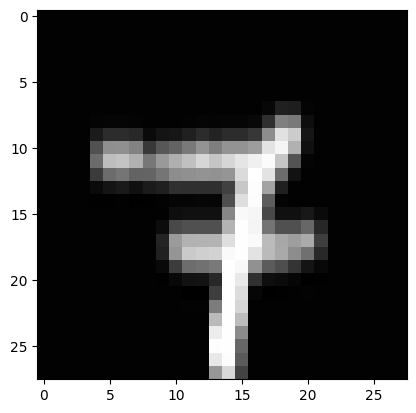

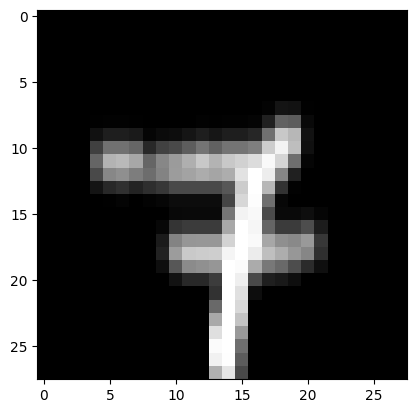

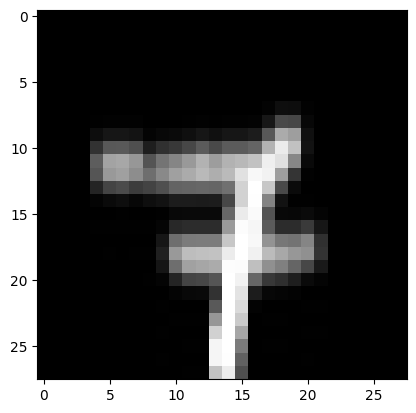

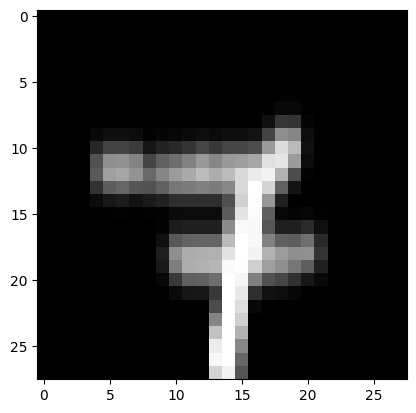

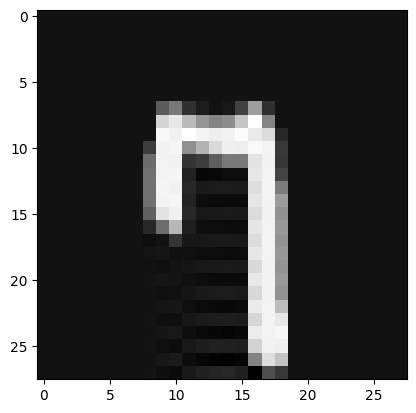

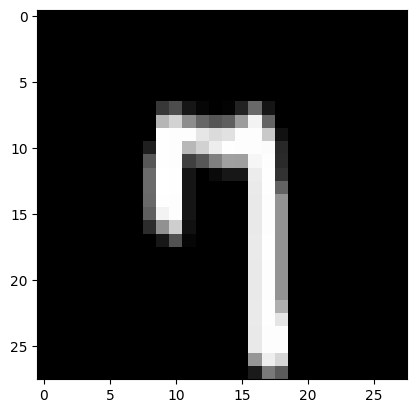

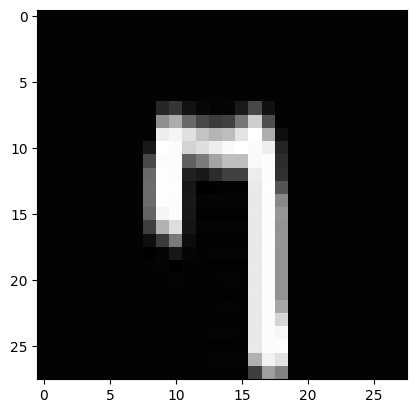

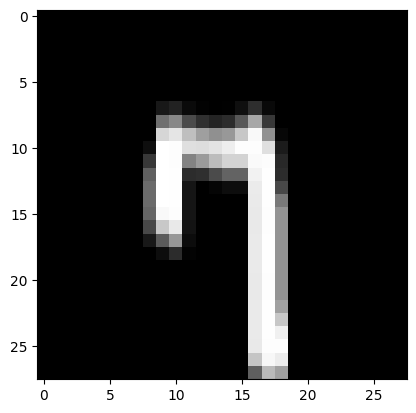

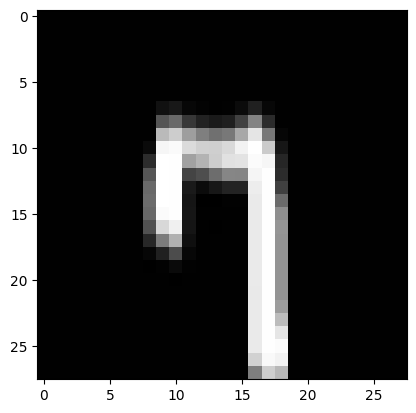

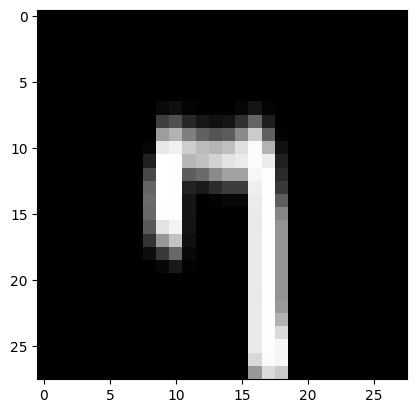

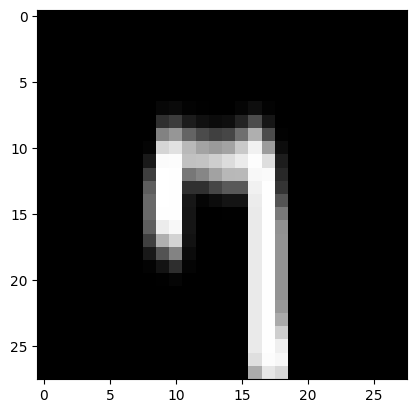

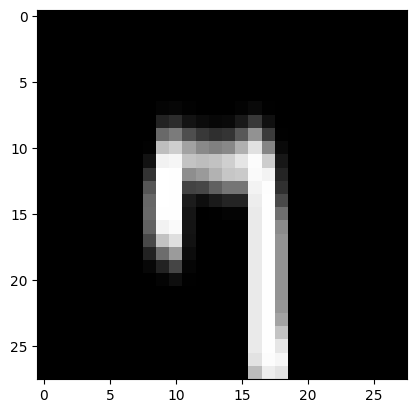

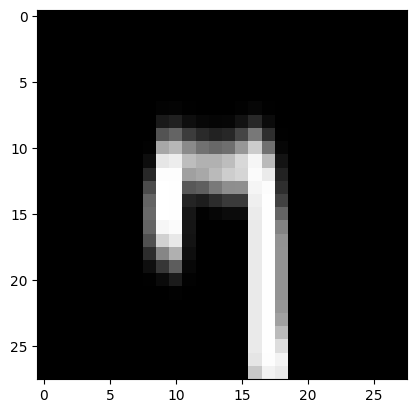

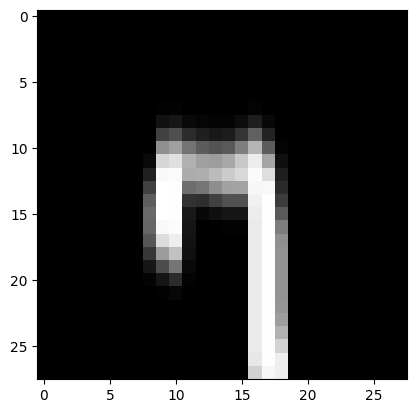

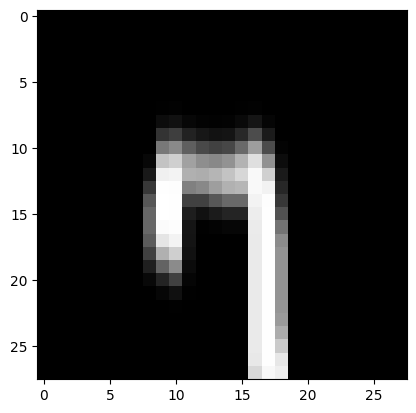

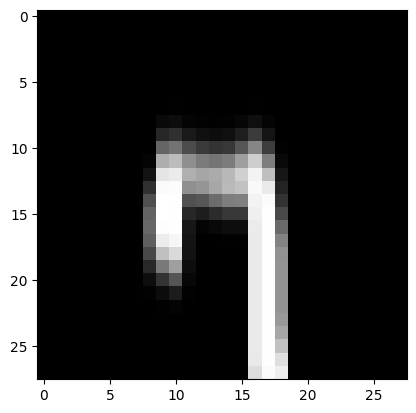

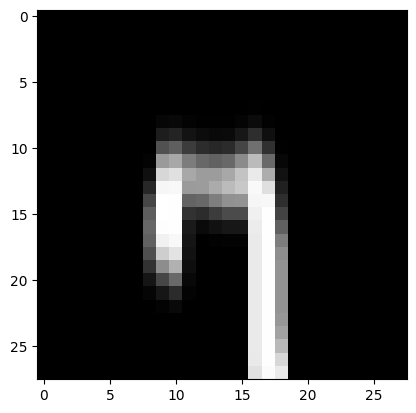

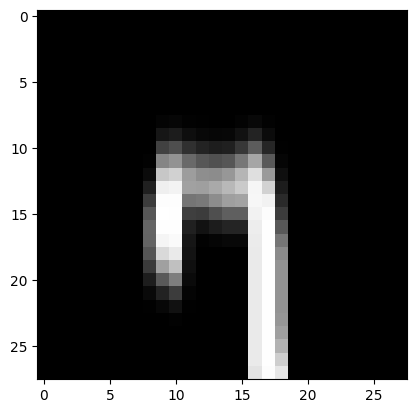

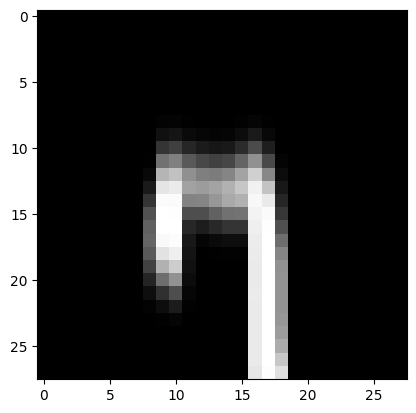

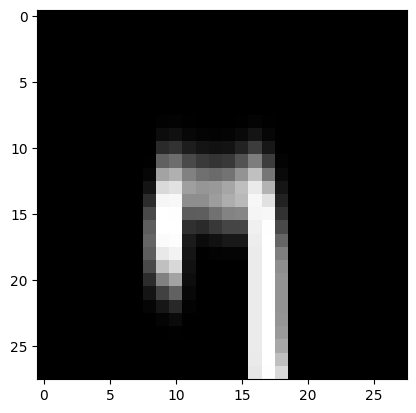

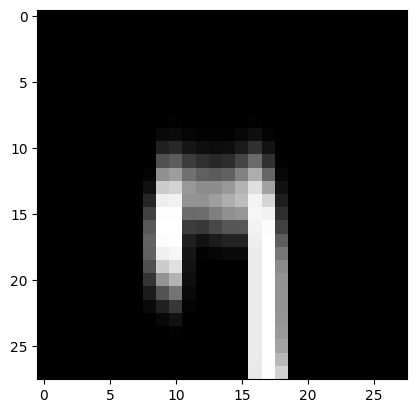

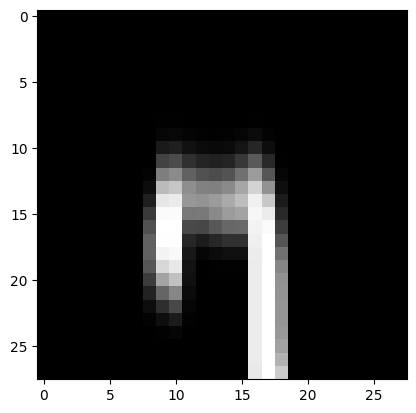

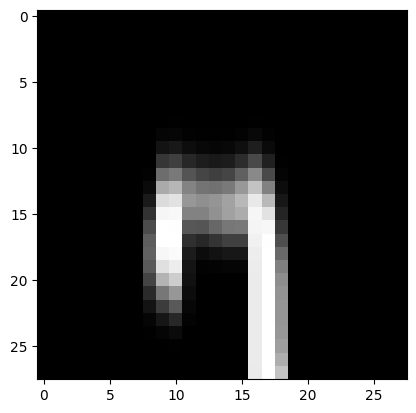

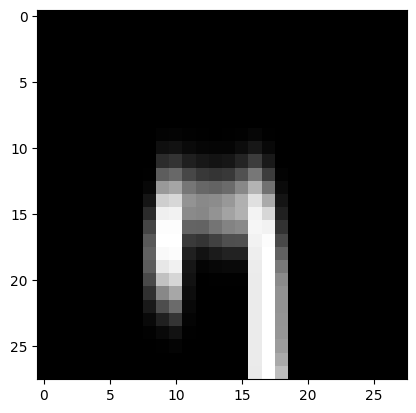

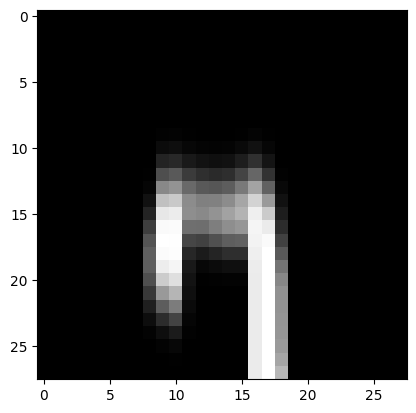

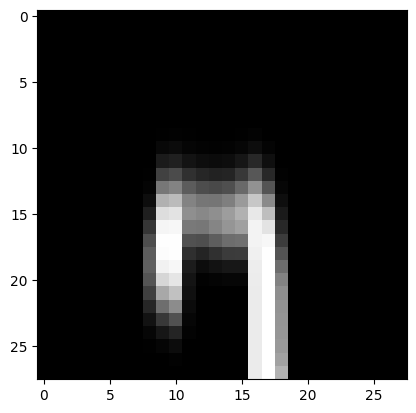

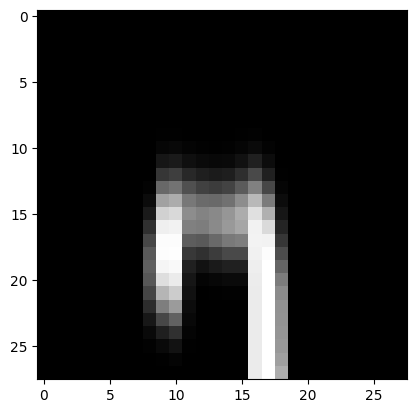

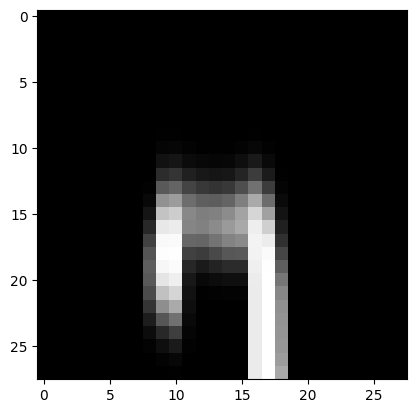

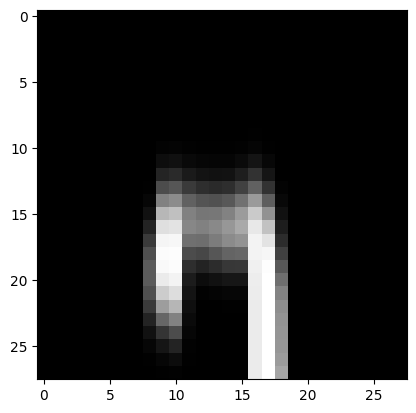

In [ ]:
first_diffs = []
for i, (img, true_label) in enumerate(zip(testX, testY)):
    print(i)
    if i > 2500:
        break
    label = np.argmax(cnn.predict(np.array([img]), verbose=0))
    if true_label != label:
        first_diffs.append(None)
        continue
    for t in [x / 10.0 for x in range(5, 200, 5)]:
        img_ = np.reshape(flow(img, t), (28, 28, 1))
        pred = np.argmax(cnn.predict(np.array([img_]), verbose=0))
        if pred != label:
            first_diffs.append(t)
            break

In [262]:
first_diffs = np.array(first_diffs)

In [263]:
len(first_diffs)

935

In [264]:
no_nones = first_diffs[first_diffs != None]

In [270]:
len(trainX)

284741

In [266]:
vals, counts = np.unique(no_nones, return_counts=True)
print(vals)

[0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0
 9.5 10.0 10.5 11.0 11.5 12.0 12.5 13.0 13.5 14.0 14.5 15.0 15.5 16.0 16.5
 17.0 17.5 18.0 18.5 19.0 19.5]


In [267]:
proportions = []
for i, count in enumerate(counts):
    if i == 0:
        proportions = [count]
    else:
        proportions.append(count + proportions[i - 1])
total = proportions[-1]
proportions = [1 - float(x) / float(total) for x in proportions]

In [269]:
for val, p in zip(vals, proportions):
    print(val, p)

0.5 0.9931662870159453
1.0 0.9908883826879271
1.5 0.9817767653758542
2.0 0.9681093394077449
2.5 0.9464692482915718
3.0 0.928246013667426
3.5 0.9043280182232346
4.0 0.8735763097949886
4.5 0.8428246013667426
5.0 0.8075170842824602
5.5 0.7619589977220956
6.0 0.734624145785877
6.5 0.6936218678815489
7.0 0.6571753986332574
7.5 0.6173120728929384
8.0 0.5740318906605922
8.5 0.530751708428246
9.0 0.4908883826879271
9.5 0.4476082004555809
10.0 0.40318906605922555
10.5 0.35421412300683375
11.0 0.33029612756264237
11.5 0.2892938496583144
12.0 0.2539863325740319
12.5 0.22779043280182232
13.0 0.19817767653758545
13.5 0.17312072892938501
14.0 0.16059225512528474
14.5 0.14578587699316625
15.0 0.12756264236902048
15.5 0.11503416856492032
16.0 0.10136674259681089
16.5 0.08883826879271073
17.0 0.07630979498861046
17.5 0.06492027334851935
18.0 0.05239179954441908
18.5 0.03986332574031892
19.0 0.019362186788154934
19.5 0.0


# Preliminary Test Data

Ran on 2903/10000 testing examples, we find that the first index of divergence is in the following (poorly organized) list. About 75% of the test data is translation invariant to 6 pixels moved downward. (Note: similar proportions hold for the first 1000 examples sampled from the training set, although those are not listed below) 

0.5 0.9907166728555514

1.0 0.9855180096546602

1.5 0.974006683995544

2.0 0.9598960267359822

2.5 0.9424433717044188

3.0 0.922020051986632

3.5 0.8993687337541775

4.0 0.8711474192350539

4.5 0.8451541032305978

5.0 0.8143334571110286

5.5 0.779056813962124

6.0 0.7456368362421092

6.5 0.7036761975492016

7.0 0.6613442257705162

7.5 0.6197549201633865

8.0 0.5770516152989231

8.5 0.5336056442629038

9.0 0.4897883401411066

9.5 0.4507983661344226

10.0 0.41106572595618274

10.5 0.36390642406238394

11.0 0.33234311177125886

11.5 0.2970664686223543

12.0 0.25993316004456

12.5 0.2354251763832157

13.0 0.21165985889342742

13.5 0.18640920906052727

14.0 0.16635722242851836

14.5 0.14630523579650945

15.0 0.12959524693650204

15.5 0.1154845896769402

16.0 0.1010025993316005

16.5 0.08986260675826219

17.0 0.07909394727070185

17.5 0.06572595618269583

18.0 0.05198663200891196

18.5 0.034162643891570754

19.0 0.016709988860007408

19.5 0.0